#AI - CA5
## Neural Networks
### AmirHossein Habibvand - 8101096447

In this assignment we are going to build a neural network using pytorch library and predict category for some product pictures.



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
!cp '/content/drive/My Drive/AI/categorized_products.zip' .
!unzip './categorized_products.zip'

Streaming output truncated to the last 5000 lines.
  inflating: categorized_products/Tshirts/8040.jpg  
  inflating: categorized_products/Tshirts/2748.jpg  
  inflating: categorized_products/Tshirts/31289.jpg  
  inflating: categorized_products/Tshirts/48241.jpg  
  inflating: categorized_products/Tshirts/48073.jpg  
  inflating: categorized_products/Tshirts/29044.jpg  
  inflating: categorized_products/Tshirts/15478.jpg  
  inflating: categorized_products/Tshirts/10338.jpg  
  inflating: categorized_products/Tshirts/52146.jpg  
  inflating: categorized_products/Tshirts/6581.jpg  
  inflating: categorized_products/Tshirts/7453.jpg  
  inflating: categorized_products/Tshirts/22807.jpg  
  inflating: categorized_products/Tshirts/7692.jpg  
  inflating: categorized_products/Tshirts/24909.jpg  
  inflating: categorized_products/Tshirts/34353.jpg  
  inflating: categorized_products/Tshirts/29247.jpg  
  inflating: categorized_products/Tshirts/37719.jpg  
  inflating: categorized_products/Ts

In [8]:
from collections import Counter, defaultdict
import torchvision
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F

import time
from datetime import timedelta
from datetime import datetime

First we define custom transform classes. Then we instantiate transform objects and the dataset with not normalized tensors.


In [9]:
class ToTensor(object):
    """Convert PIL Images in sample to pytorch Tensors."""
    
    ## the input image must be grayscaled first
    def __call__(self, image):
        image = np.array(image, dtype=np.float32)
        # numpy image: H x W
        return torch.from_numpy(image)

class ToNormalTensor(object):
    """Convert PIL Images in sample to pytorch normal Tensors."""
    
    ## the input image must be grayscaled first
    def __call__(self, image):
        image = np.array(image, dtype=np.float32) / 255 # maxmium value for each color
        # numpy image: H x W
        return torch.from_numpy(image)

In [10]:
transform = transforms.Compose([
  transforms.Grayscale(),
  ToTensor(),
])

dataset = ImageFolder('./categorized_products',
                      transform=transform)

indices = range(len(dataset)) # indices of the dataset
classes = dataset.classes

# Part 1


Let's see some sample imagaes from dataset:



12 22


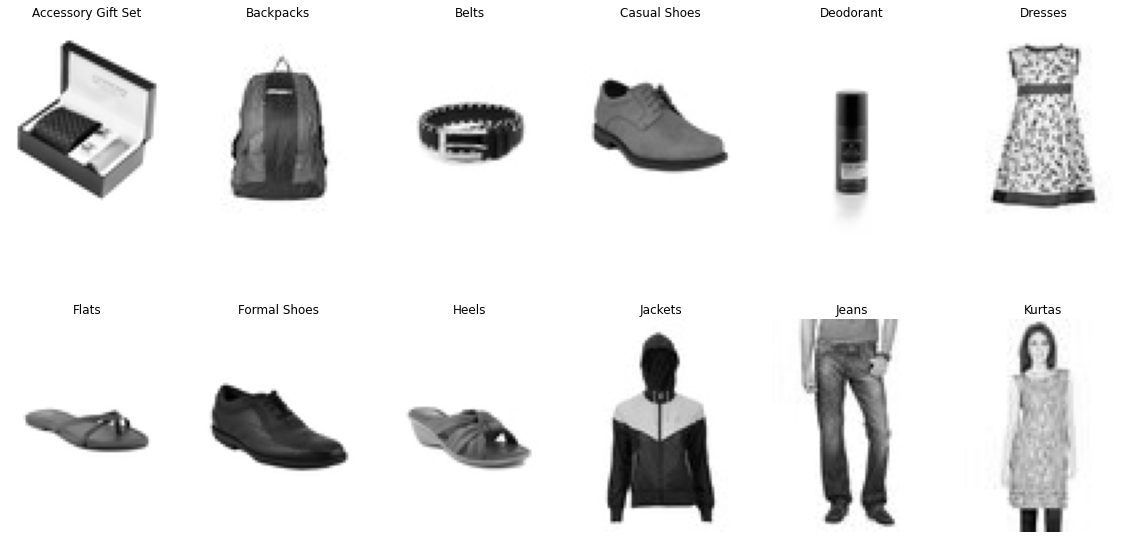

In [ ]:
nRows = 2
nCols = 6

def imshow(images, label, classes):
    _, axs = plt.subplots(nRows, nCols,figsize=(20, 10)) 
    for i in range(nRows):
      for j in range(nCols):
        img_index = i * nCols + j
        axs[i][j].imshow(images[img_index], cmap='gray')
        axs[i][j].set_title(classes[labels[img_index]])
        axs[i][j].axis('off')
    
    plt.show()

images, labels, seen_labels = [] , [], []
for i in indices:
  if len(labels) == (nRows * nCols):
    break
  image , label = dataset[i]
  if label not in seen_labels:
    seen_labels.append(label)
    if random.random() < 0.4:
        images.append(image)
        labels.append(label)
        
print(len(labels), len(seen_labels))
imshow(images, labels, classes)

# Part 2

And plot the product categories distribution:

Text(0.5, 0, 'categories')

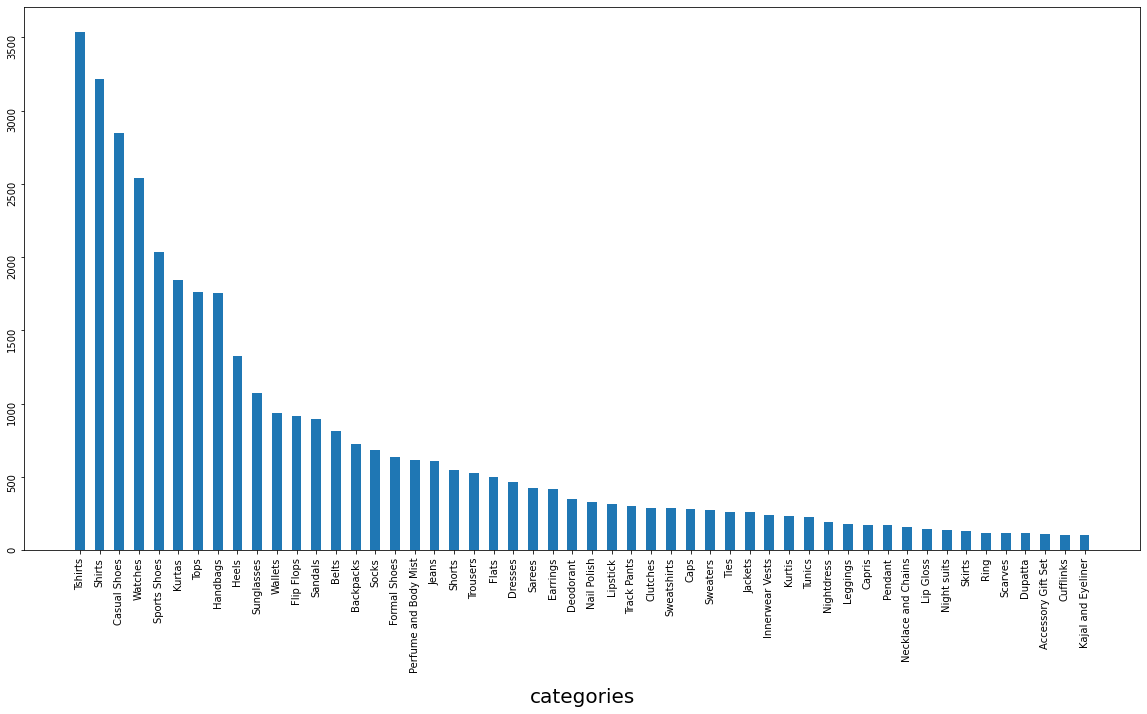

In [ ]:
def get_category_counts(dataset):
    category_counter = Counter()
    for _, label in dataset:
        category_counter[label] += 1
    return category_counter.most_common()

category_lables, category_counts = zip(*get_category_counts(dataset))
category_lables = [classes[l] for l in category_lables]

_, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.bar(category_lables, category_counts, width=0.5)
ax.tick_params(labelrotation=90)
ax.set_xlabel("categories",labelpad=15, size=20)

# Part 3

Now let's split the dataset into test and train sets, the scikit learn train_test_split is used with the stratify option to separate 20% of each class as test dataset.


In [11]:
targets = dataset.targets
train_indices, test_indices, _, _ = train_test_split(indices, targets,
    test_size=0.2, stratify=targets)

batch_size = 64

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=16)

# train_classes = [classes[dataset.targets[i]] for i in train_indices]
# train_counter = Counter(train_classes)

# test_classes = [classes[dataset.targets[i]] for i in test_indices]
# test_counter = Counter(test_classes)

# train_counter.most_common(5)
# test_counter.most_common(5)


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The model can be initiated with variable linear layers. Then the fit and test accuracu functions are provided.

In [13]:
class Model(nn.Module):
    def __init__(self, layer_configs, act=F.relu):
        super(Model, self).__init__()

        self.act = act
        self.layer_count = len(layer_configs)
        for i, layer_config in enumerate(layer_configs):
            setattr(self, f'layer{i}', nn.Linear(*layer_config))

    def forward(self, x):
        x = x.view(x.size(0), -1)

        for i in range(self.layer_count):
            if i > 0:
                x = self.act(x)
            x = getattr(self, f'layer{i}')(x)

        return x

In [14]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs=10):

    total_time = 0.
    average_loss_list = []

    for epoch in range(num_epochs):
        train_loss = 0.
        d1 = datetime.now()
        for images, labels in train_loader:

            images = images.to(device)
            labels = labels.to(device)

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()
            train_loss += loss.item()

        average_loss = train_loss / len(train_loader)
        average_loss_list.append(average_loss)
        d2 = datetime.now()
        delta = d2 - d1
        seconds = float(delta.total_seconds())
        total_time += seconds
        print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' %
              (epoch + 1, average_loss, seconds))

    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.bar(list(range(1, num_epochs + 1)), average_loss_list, width=0.5)
    ax.set_xlabel("average loss", labelpad=15, size=20)
    print('total training time: %.3f minutes' % (total_time / 60))


In [15]:
def test_model_accuracy(model, loader, device):

    total_counter = Counter()
    correct_counter = Counter()

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            predictedToCpu = predicted.to('cpu')
            for i in range(labels.size(0)):
                total_counter[int(str(labels[i])[7:][:-1])] += 1
                if predictedToCpu[i] == labels[i]:
                    correct_counter[int(str(labels[i])[7:][:-1])] += 1

    accuracy = 100 * sum(correct_counter.values()) / \
        sum(total_counter.values())

    print('Accuracy: {}%'.format(accuracy))

    return total_counter, correct_counter

def plot_result(test_total_counter, test_correct_counter,
            train_total_counter, train_correct_counter,
            classes):

    test_counts = [test_correct_counter[i] / test_total_counter[i]
                   for i in sorted(test_total_counter.keys())]

    train_counts = [train_correct_counter[i] / train_total_counter[i]
                    for i in sorted(train_total_counter.keys())]

    X = np.arange(len(classes))
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.bar(X + 0.00, test_counts, color='r', width=0.25)
    ax.bar(X + 0.5, train_counts, color='b', width=0.25)
    plt.xticks(X + 0.25, classes)
    ax.tick_params(labelrotation=90)
    ax.set_xlabel("product categories", labelpad=15, size=20)
    plt.legend(["test", "train"])



Different models with 4 and 5 layers and variable neurons in each layer are trained and tested over the dataset:

In [16]:
INPUT_SIZE = 80 * 60
OUTPUT_SIZE = len(classes)
def create_layer_config(counts):
    counts = [INPUT_SIZE, *counts, OUTPUT_SIZE]
    return [
        [counts[i], counts[i+1]]
        for i in range(len(counts) - 1)
    ]

configs = [
    create_layer_config([
        INPUT_SIZE * 2,
        INPUT_SIZE // 2 ,
        INPUT_SIZE // 4,
    ]),
    create_layer_config([
        INPUT_SIZE * 2,
        INPUT_SIZE // 4 ,
        INPUT_SIZE // 8,
    ]),
    create_layer_config([
        INPUT_SIZE * 2,
        INPUT_SIZE // 4 ,
        INPUT_SIZE // 8,
        INPUT_SIZE // 16,
    ]),
    create_layer_config([
        INPUT_SIZE * 2,
        INPUT_SIZE // 4 ,
        INPUT_SIZE // 12,
        INPUT_SIZE // 24,
    ]),
]


In [30]:
params = list(Model(configs[0]).parameters())

for param in params:
    print(param.shape)

torch.Size([9600, 4800])
torch.Size([9600])
torch.Size([2400, 9600])
torch.Size([2400])
torch.Size([1200, 2400])
torch.Size([1200])
torch.Size([52, 1200])
torch.Size([52])


As we can see, there are different parameters in the model, some of them (with two counts, first one as output and the second one as the input of layer) are for neurons and the others are for bias.

config #0
epoch 1, train_loss: nan, time elapsed: 18.130825 seconds
epoch 2, train_loss: nan, time elapsed: 18.104739 seconds
epoch 3, train_loss: nan, time elapsed: 18.095791 seconds
epoch 4, train_loss: nan, time elapsed: 18.122168 seconds
epoch 5, train_loss: nan, time elapsed: 17.902934 seconds
epoch 6, train_loss: nan, time elapsed: 18.135786 seconds
epoch 7, train_loss: nan, time elapsed: 18.024786 seconds
epoch 8, train_loss: nan, time elapsed: 18.094097 seconds
epoch 9, train_loss: nan, time elapsed: 18.034237 seconds
epoch 10, train_loss: nan, time elapsed: 18.106619 seconds
total training time: 3.013 minutes
Accuracy: 0.2953020134228188%
Accuracy: 0.29866774052820566%
config #1
epoch 1, train_loss: nan, time elapsed: 16.358891 seconds
epoch 2, train_loss: nan, time elapsed: 16.289833 seconds
epoch 3, train_loss: nan, time elapsed: 16.4319 seconds
epoch 4, train_loss: nan, time elapsed: 16.447265 seconds
epoch 5, train_loss: nan, time elapsed: 16.32652 seconds
epoch 6, train_l

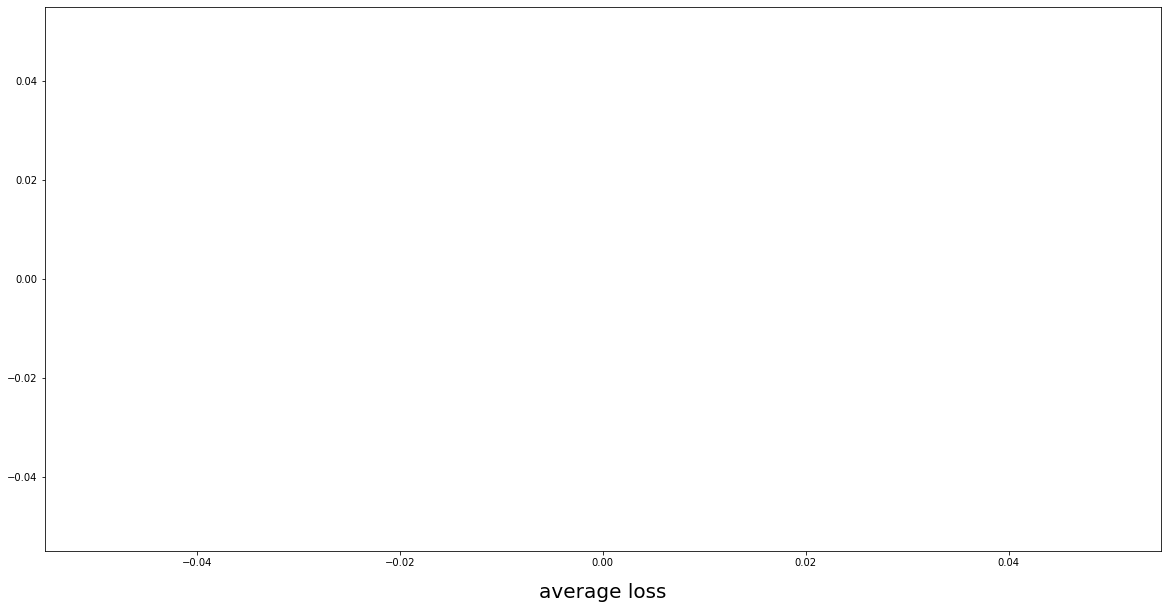

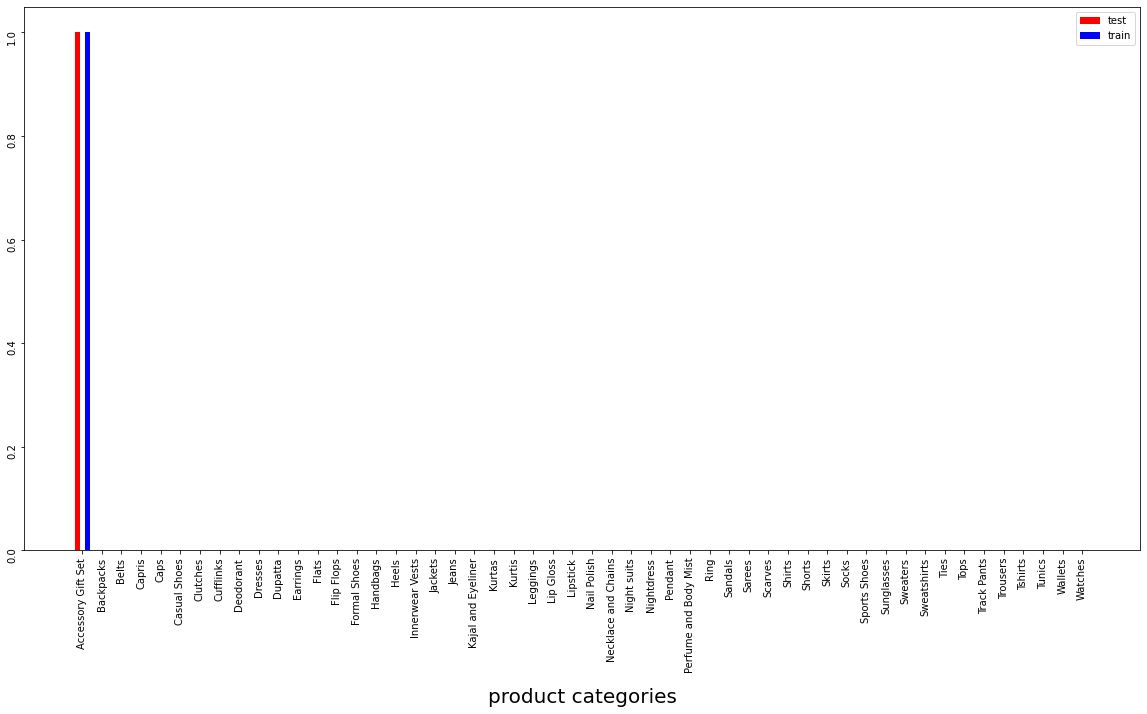

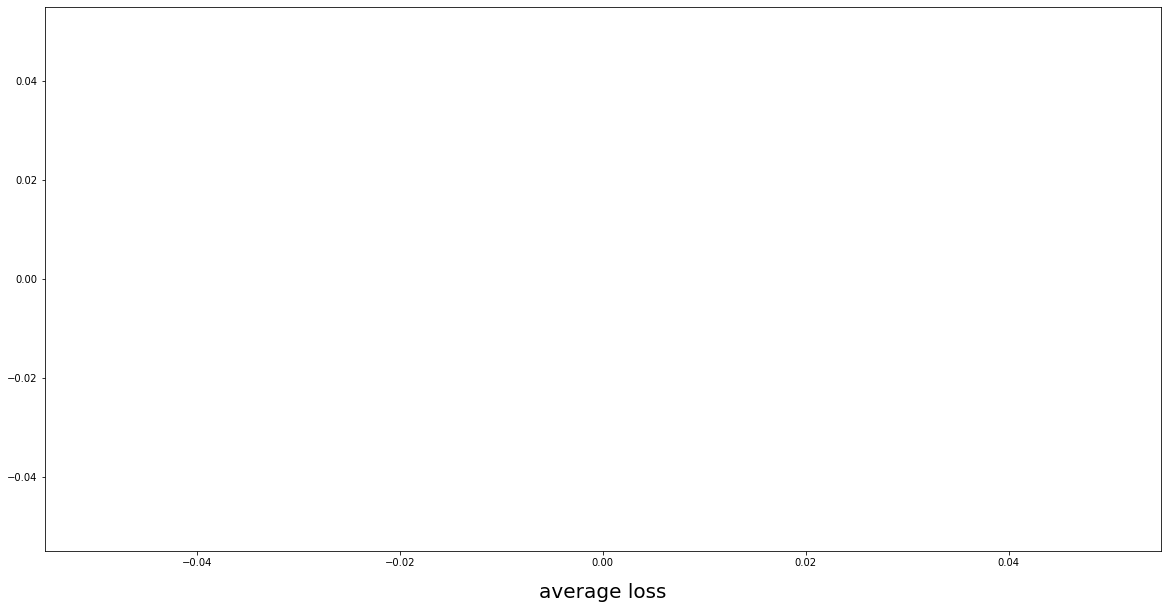

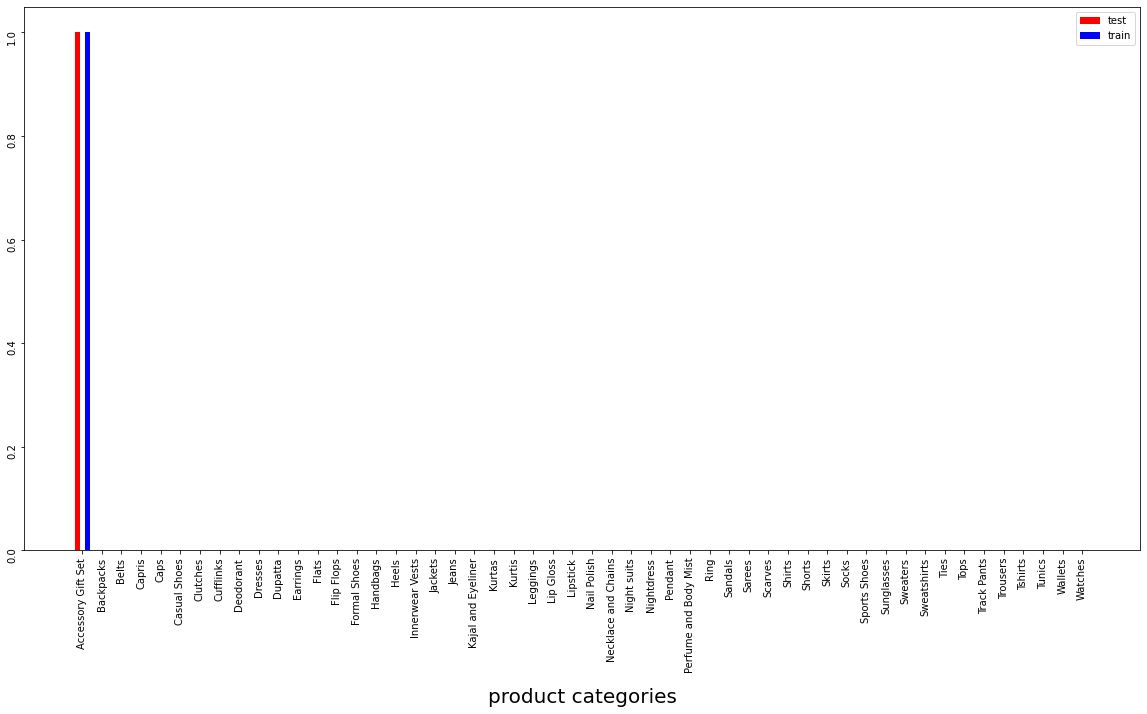

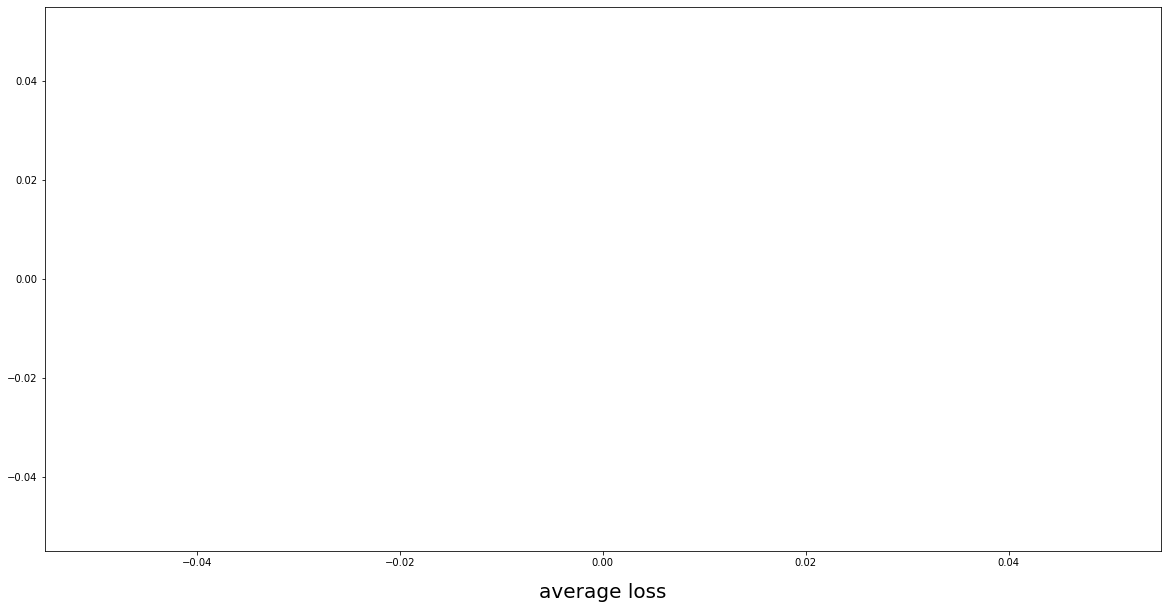

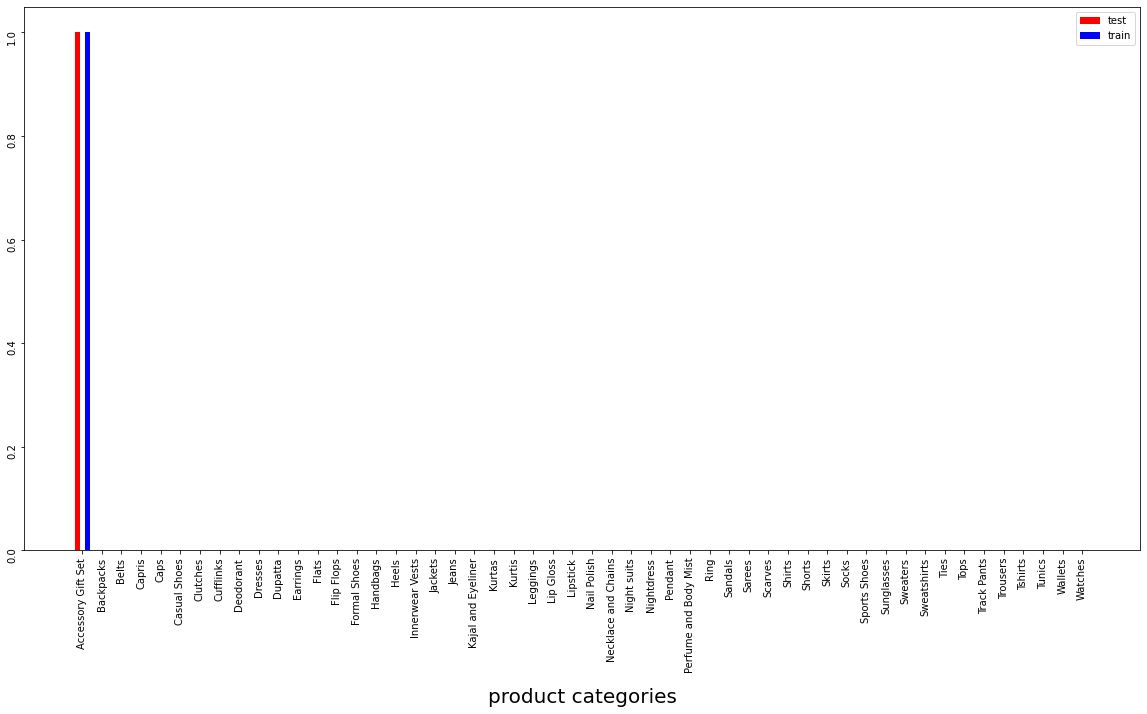

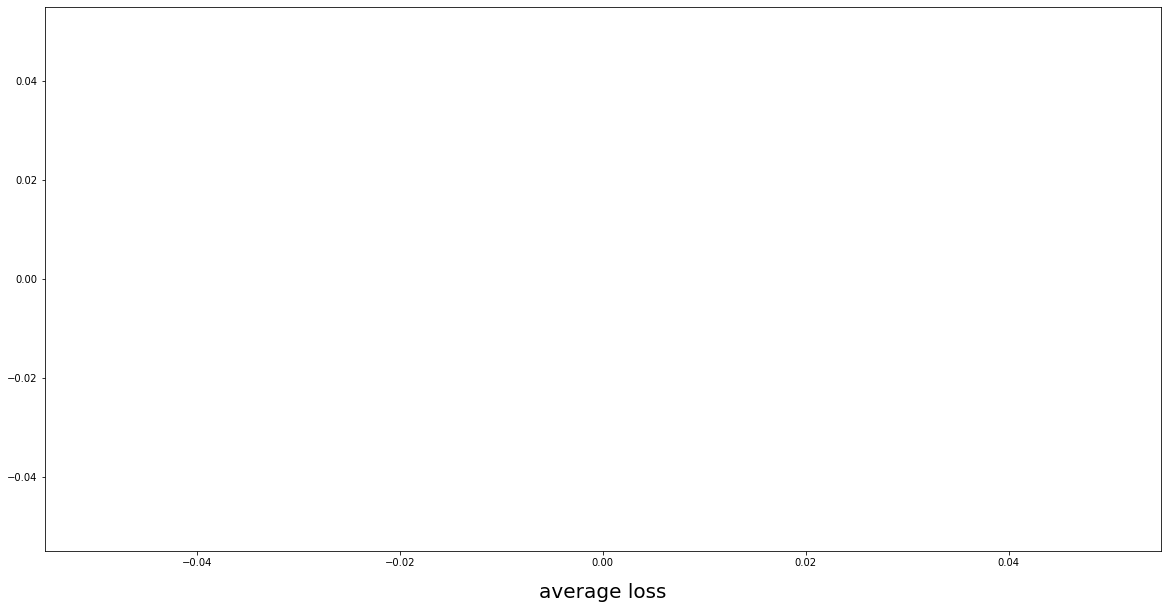

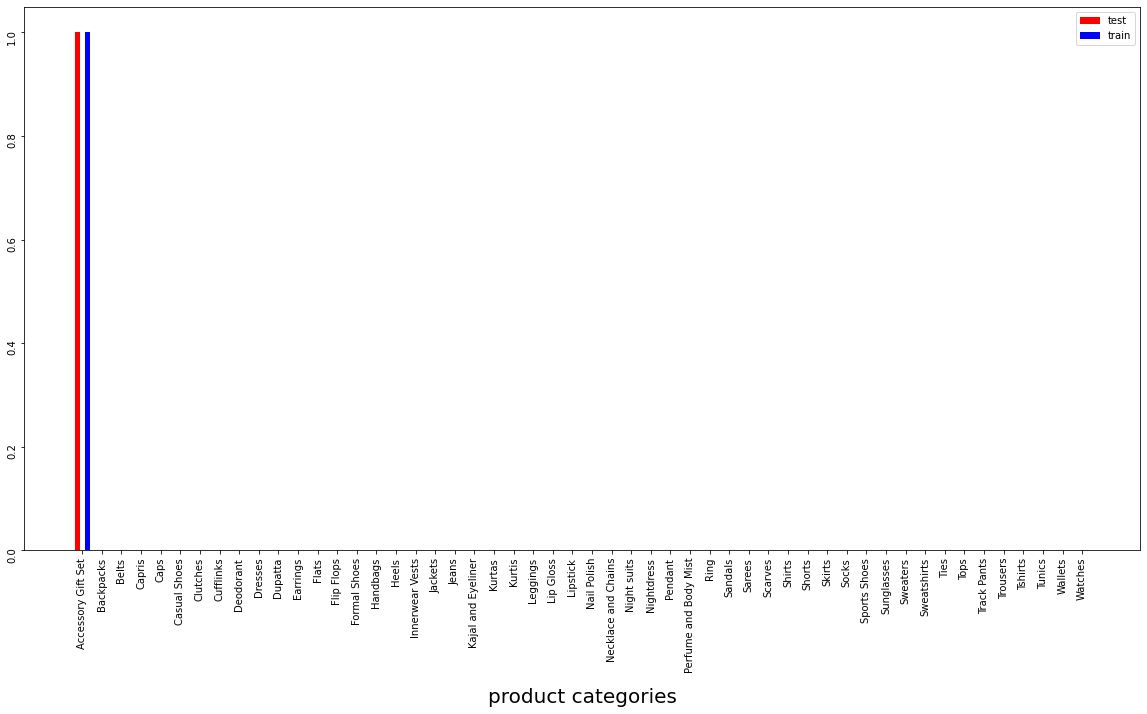

In [ ]:
for i, config in enumerate(configs):
    print(f'config #{i}')

    model = Model(config).to(device)

    learning_rate = 0.01
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    fit(model, train_loader, device, criterion, optimizer)

    test_total_counter, test_correct_counter = test_model_accuracy(
        model, test_loader, device)
    train_total_counter, train_correct_counter = test_model_accuracy(
        model, train_loader, device)

    plot_result(test_total_counter, test_correct_counter,
                train_total_counter, train_correct_counter,
                classes)4

So we can see that without normalizing the tensors, the data loss is NaN because it becomes too big as the numbers from images are in range of [0, 255].
And as the weights are not getting updated the model will predict 0 for all of the test images.


# Part 4

Now lets normalize the tensors ans see the effect:


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(),
    ToNormalTensor()
])
dataset = ImageFolder('./categorized_products', transform=transform)
classes = dataset.classes
indices = range(len(dataset))  # indices of the dataset

validation_split = 0.8
targets = dataset.targets
train_indices, test_indices, _, _ = train_test_split(indices, targets,
                                                        test_size=0.2,
                                                        stratify=targets)

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler, num_workers=16)


Some helper functions to evaluate different models.

defaults can be seen from evaluate model default arguments. The optimizer is Stochastic Gradient Descent (SGD) and default activation function is Relu. The default learning_rate, number of epochs, batch size and momentum are 0.01, 10, 64, and 0.1 respectively. The weights in model layers are initialized randomly by pytorch. Tensors are also normalized by default from now on.

In [ ]:
def set_weights_to_zero(layer):
    if type(layer) == nn.Linear:
        nn.init.zeros_(layer.weight)
        layer.bias.data.fill_(0)

def evaluate_model(
        model_config,
        learning_rate=0.01,
        epochs=10,
        batch_size=64,
        act=F.relu,
        set_initial_weights_to_zero=False,
        momentum=0.1,
        weight_decay=0):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = Model(model_config)
    if(set_initial_weights_to_zero):
        model.apply(set_weights_to_zero)

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=learning_rate,
        momentum=momentum,
        weight_decay=weight_decay)

    fit(model, train_loader, device, criterion, optimizer, epochs)

    test_total_counter, test_correct_counter = test_model_accuracy(
        model, test_loader, device)
    train_total_counter, train_correct_counter = test_model_accuracy(
        model, train_loader, device)

    plot_result(test_total_counter, test_correct_counter,
                train_total_counter, train_correct_counter,
                classes)


config #0
epoch 1, train_loss: 3.014, time elapsed: 21.722666 seconds
epoch 2, train_loss: 2.155, time elapsed: 21.607101 seconds
epoch 3, train_loss: 1.763, time elapsed: 21.516043 seconds
epoch 4, train_loss: 1.562, time elapsed: 21.508239 seconds
epoch 5, train_loss: 1.430, time elapsed: 21.449461 seconds
epoch 6, train_loss: 1.345, time elapsed: 21.316629 seconds
epoch 7, train_loss: 1.265, time elapsed: 21.414285 seconds
epoch 8, train_loss: 1.219, time elapsed: 21.37348 seconds
epoch 9, train_loss: 1.164, time elapsed: 21.38967 seconds
epoch 10, train_loss: 1.136, time elapsed: 21.717597 seconds
total training time: 3.584 minutes
Accuracy: 62.45637583892618%
Accuracy: 63.364542434309875%
config #1
epoch 1, train_loss: 3.061, time elapsed: 18.857184 seconds
epoch 2, train_loss: 2.200, time elapsed: 18.697442 seconds
epoch 3, train_loss: 1.812, time elapsed: 18.805337 seconds
epoch 4, train_loss: 1.598, time elapsed: 18.803468 seconds
epoch 5, train_loss: 1.472, time elapsed: 18.77

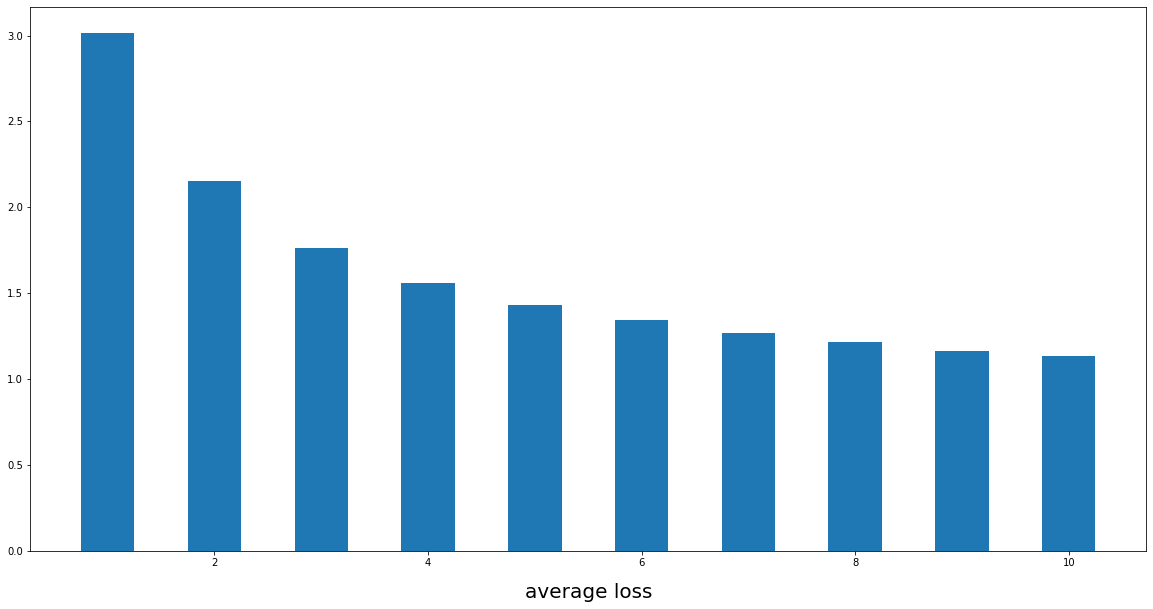

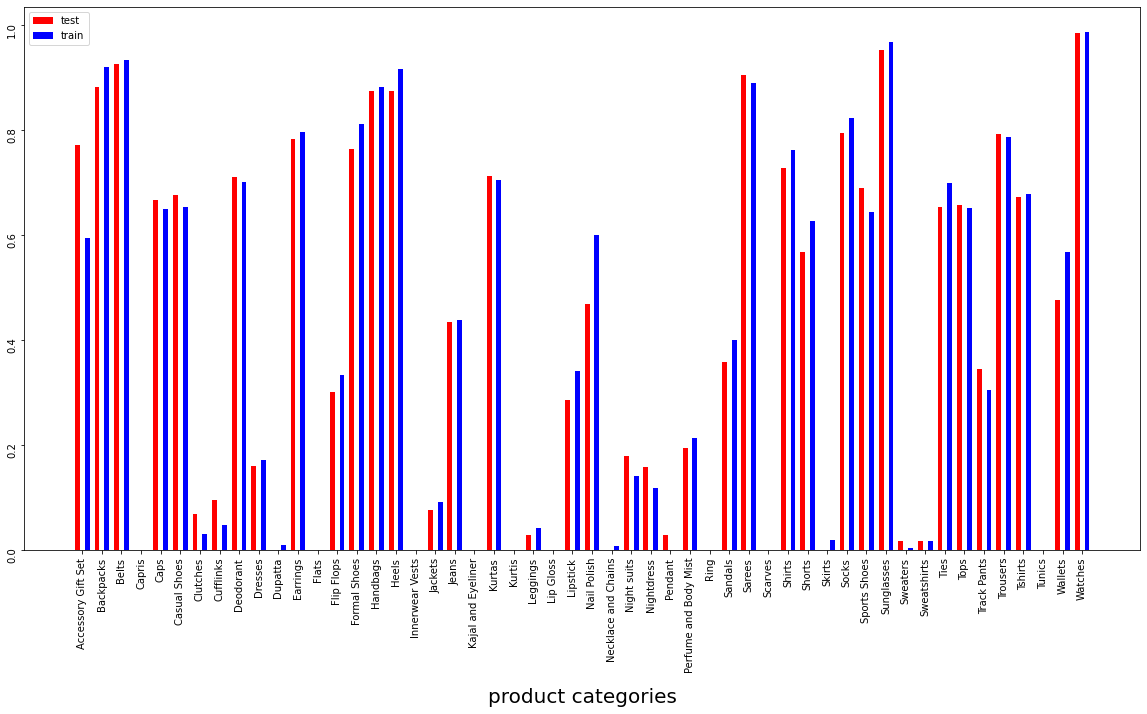

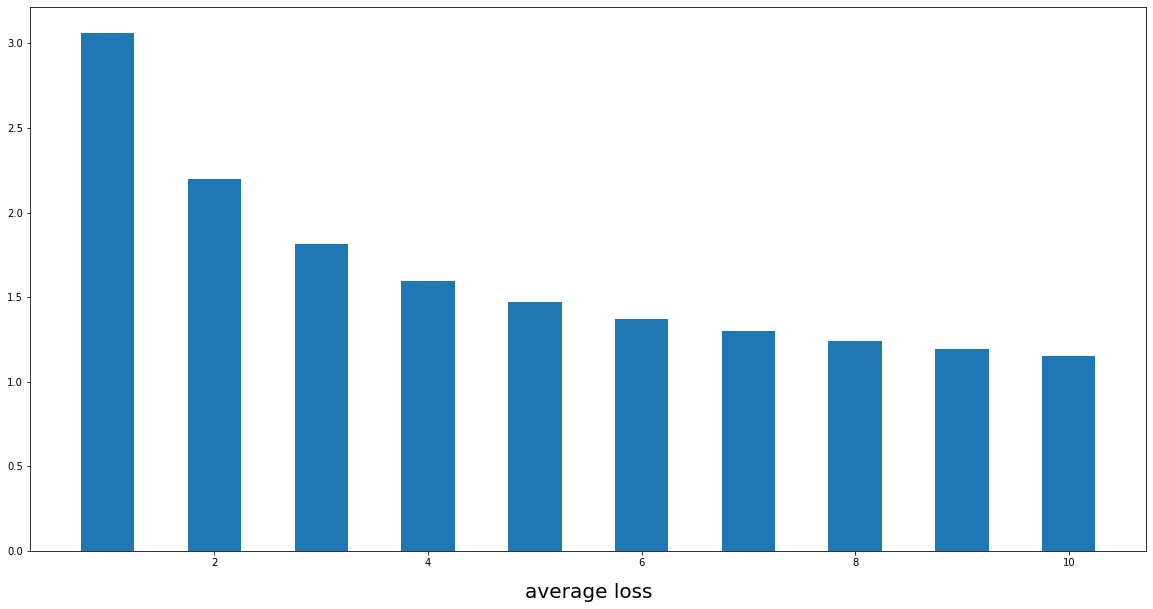

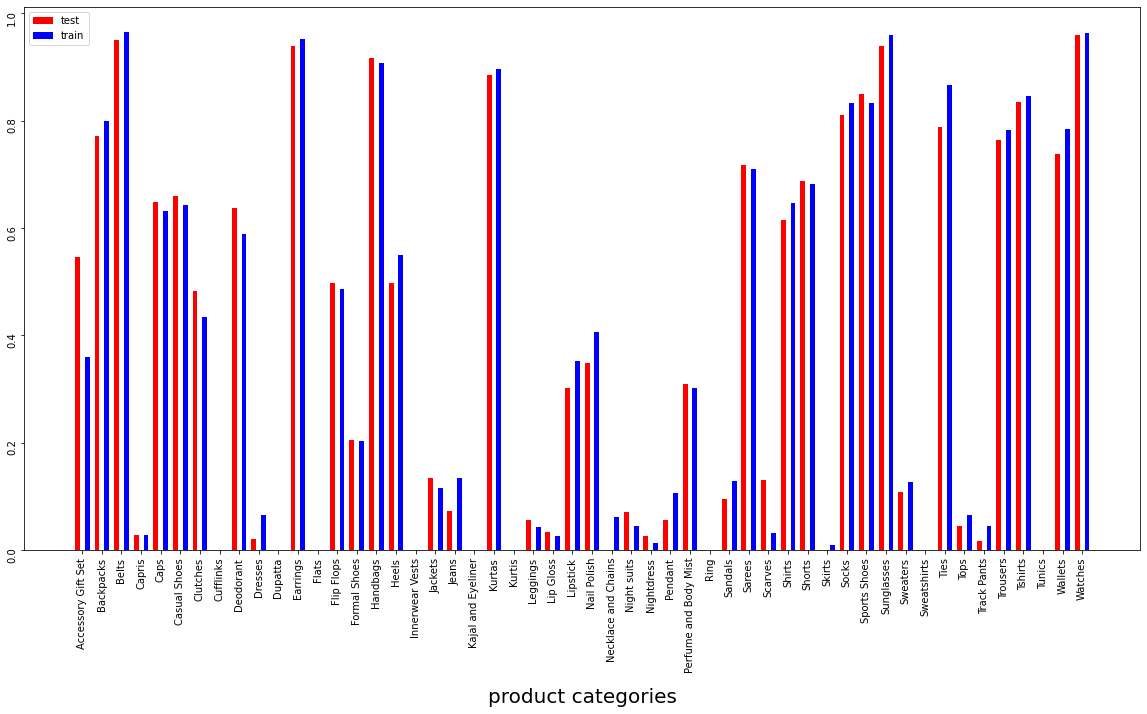

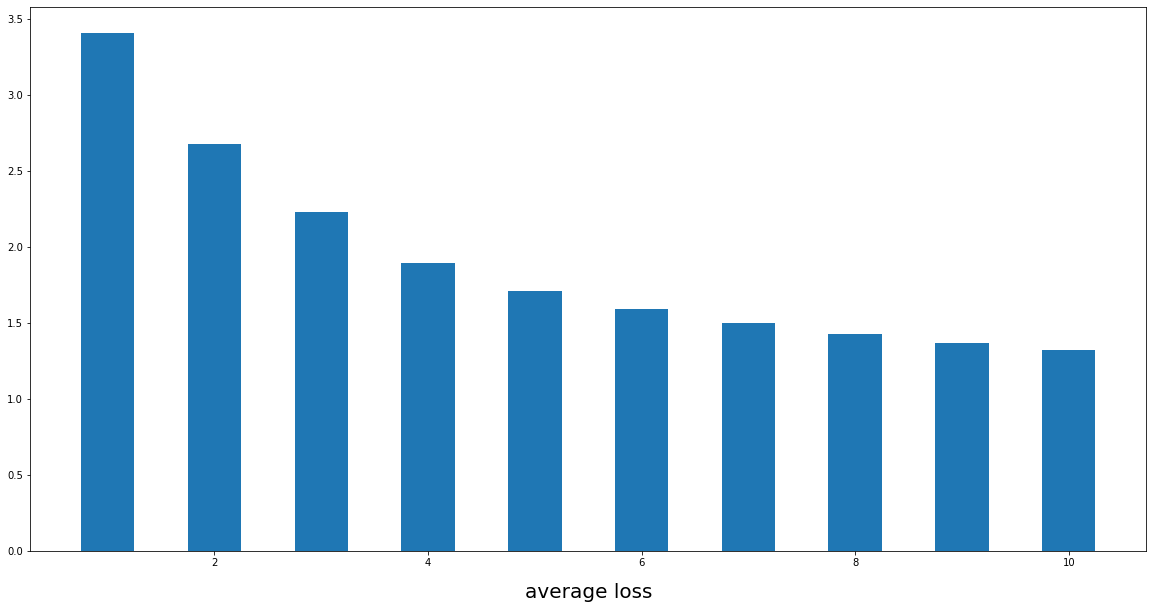

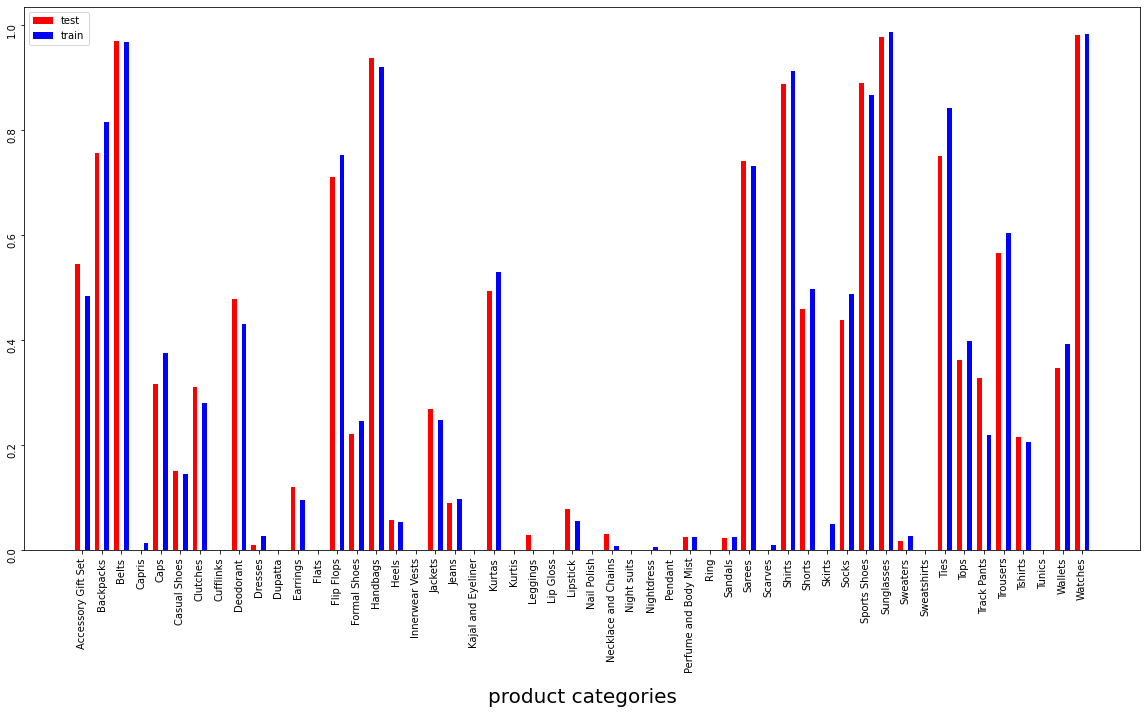

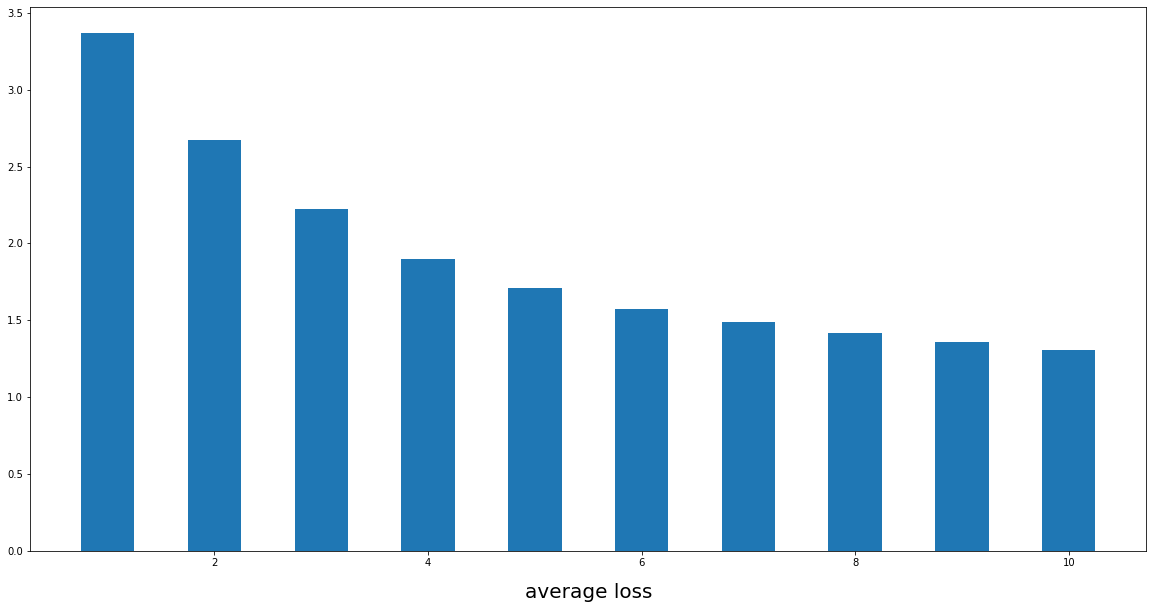

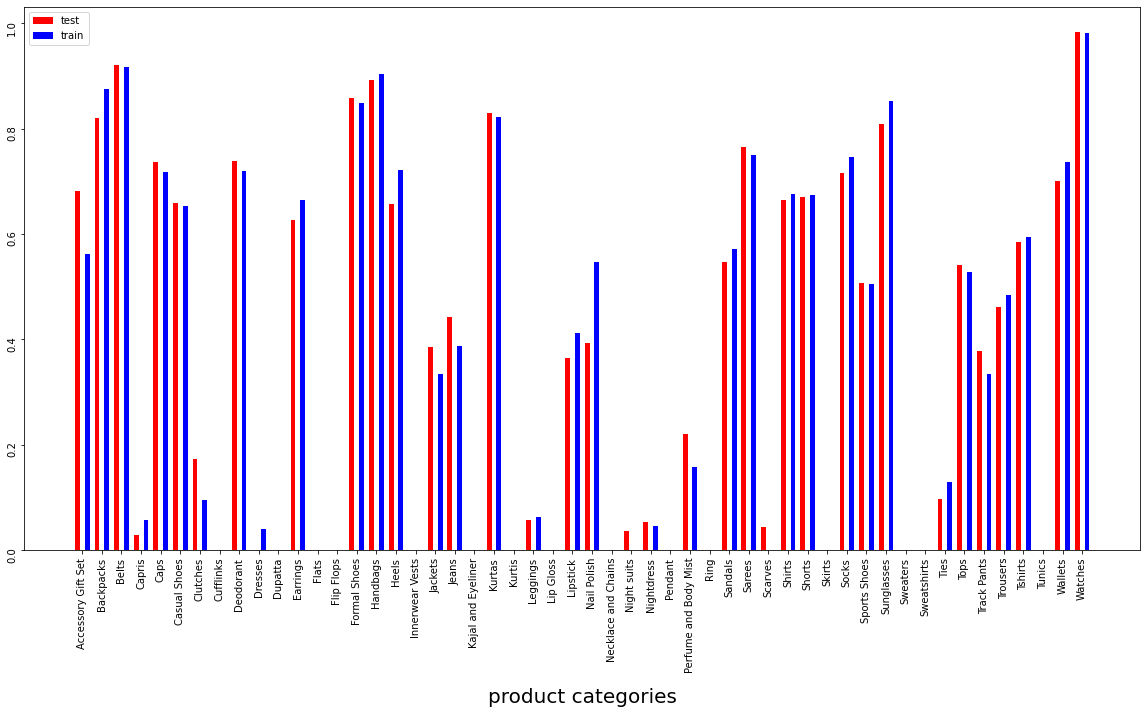

In [ ]:
for i, config in enumerate(configs):
    print(f'config #{i}')

    evaluate_model(config)


As we can see, there is a remarkable progress in the accuracy by normalizing the tensors, we can also see the average loss in layers as the numbers get small between zero and one. The best model is the first one, we will use that config for next parts:



In [31]:
best_layer_config = configs[0]

# Part 5

Now lets see the effect of initial weights on network, we will set them to zero and see the results:

epoch 1, train_loss: 3.890, time elapsed: 21.51299 seconds
epoch 2, train_loss: 3.784, time elapsed: 21.547958 seconds
epoch 3, train_loss: 3.702, time elapsed: 21.552872 seconds
epoch 4, train_loss: 3.642, time elapsed: 21.594268 seconds
epoch 5, train_loss: 3.598, time elapsed: 21.694286 seconds
epoch 6, train_loss: 3.566, time elapsed: 21.585336 seconds
epoch 7, train_loss: 3.543, time elapsed: 22.090544 seconds
epoch 8, train_loss: 3.526, time elapsed: 21.592865 seconds
epoch 9, train_loss: 3.513, time elapsed: 21.52373 seconds
epoch 10, train_loss: 3.503, time elapsed: 21.536234 seconds
total training time: 3.604 minutes
Accuracy: 9.48993288590604%
Accuracy: 9.48689553340716%


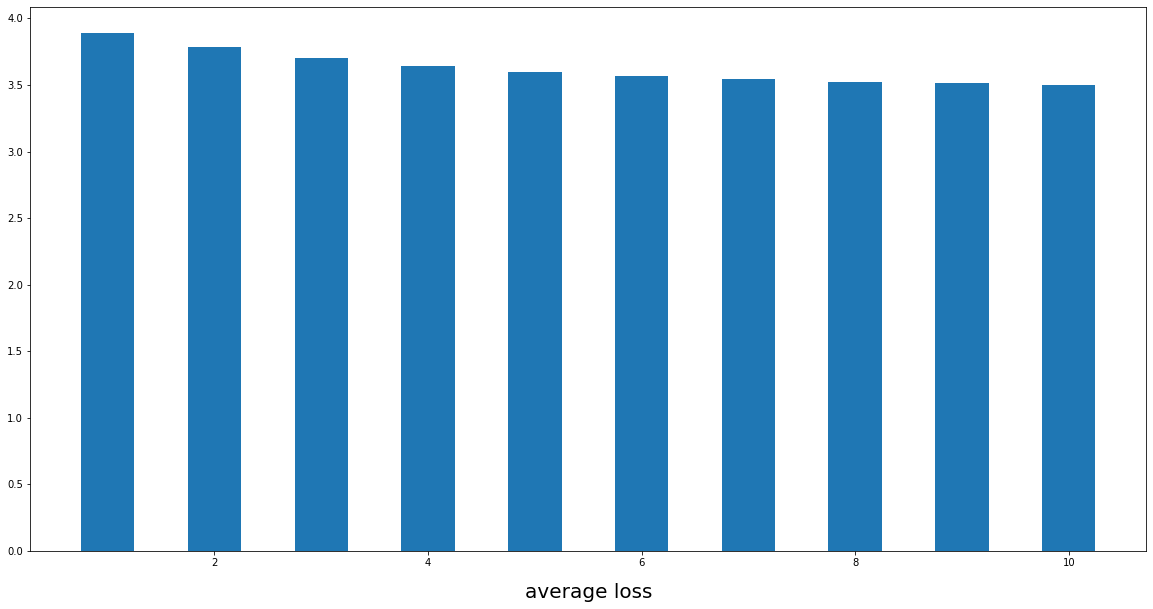

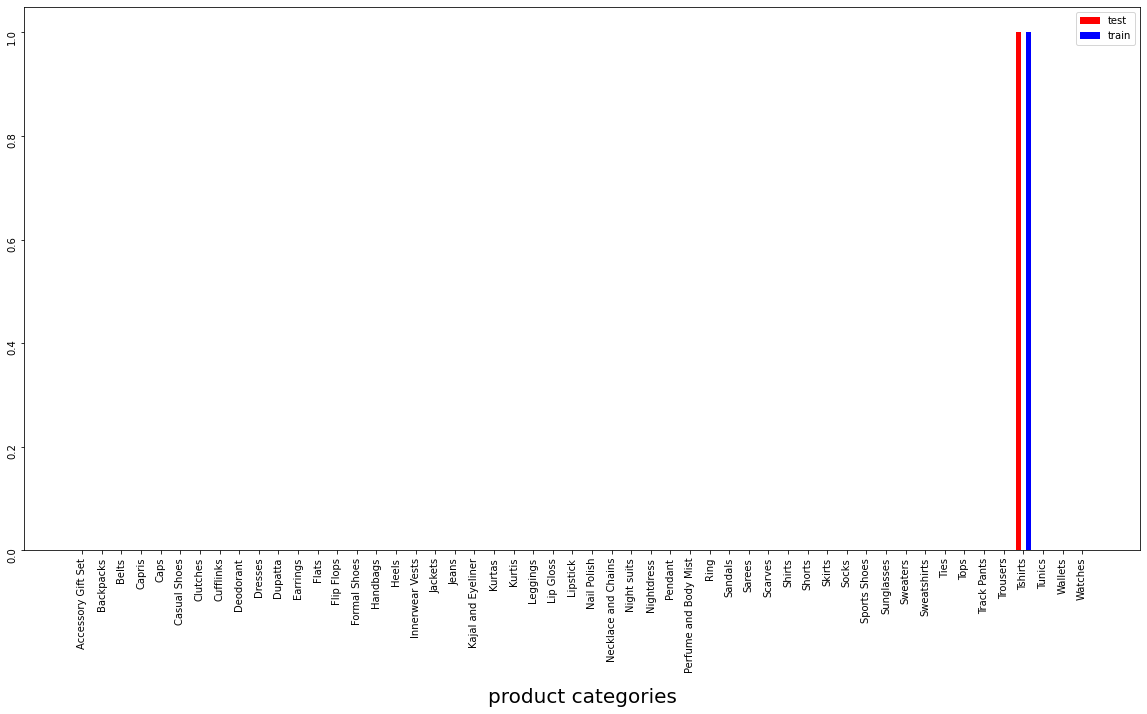

In [ ]:
evaluate_model(
    model_config=best_layer_config,
    set_initial_weights_to_zero=True
)

By setting initial weights to zero, we will get only the bias of last layer which as affected by the most common category (T-Shirts), so we only have T-Shirts as predicted output. So we will use random weights afterward.

The initial weights of model must be unbiased, so using a random starting weights seems to be a good idea. They also help us to prevent getting stuck at local mimnimums. However they may face 2 problems known as vanishing and exploding gradients, the first one is when the gradients are too small that they don't change weights as much as needed, the other one is when gradients are too big and update the weights more than needed resulting in unstable network.

# Part 6

Now let's check affect of learning rate on the model:

epoch 1, train_loss: 3.650, time elapsed: 21.543771 seconds
epoch 2, train_loss: 3.400, time elapsed: 21.528022 seconds
epoch 3, train_loss: 3.312, time elapsed: 21.661701 seconds
epoch 4, train_loss: 3.172, time elapsed: 21.565996 seconds
epoch 5, train_loss: 2.999, time elapsed: 21.631484 seconds
epoch 6, train_loss: 2.849, time elapsed: 21.692442 seconds
epoch 7, train_loss: 2.725, time elapsed: 21.615147 seconds
epoch 8, train_loss: 2.610, time elapsed: 21.565738 seconds
epoch 9, train_loss: 2.503, time elapsed: 21.556544 seconds
epoch 10, train_loss: 2.403, time elapsed: 21.715767 seconds
total training time: 3.601 minutes
Accuracy: 30.536912751677853%
Accuracy: 30.447330447330447%
epoch 1, train_loss: 3.040, time elapsed: 21.500385 seconds
epoch 2, train_loss: 2.176, time elapsed: 21.677415 seconds
epoch 3, train_loss: 1.781, time elapsed: 21.601731 seconds
epoch 4, train_loss: 1.582, time elapsed: 21.647849 seconds
epoch 5, train_loss: 1.449, time elapsed: 21.653791 seconds
epoc

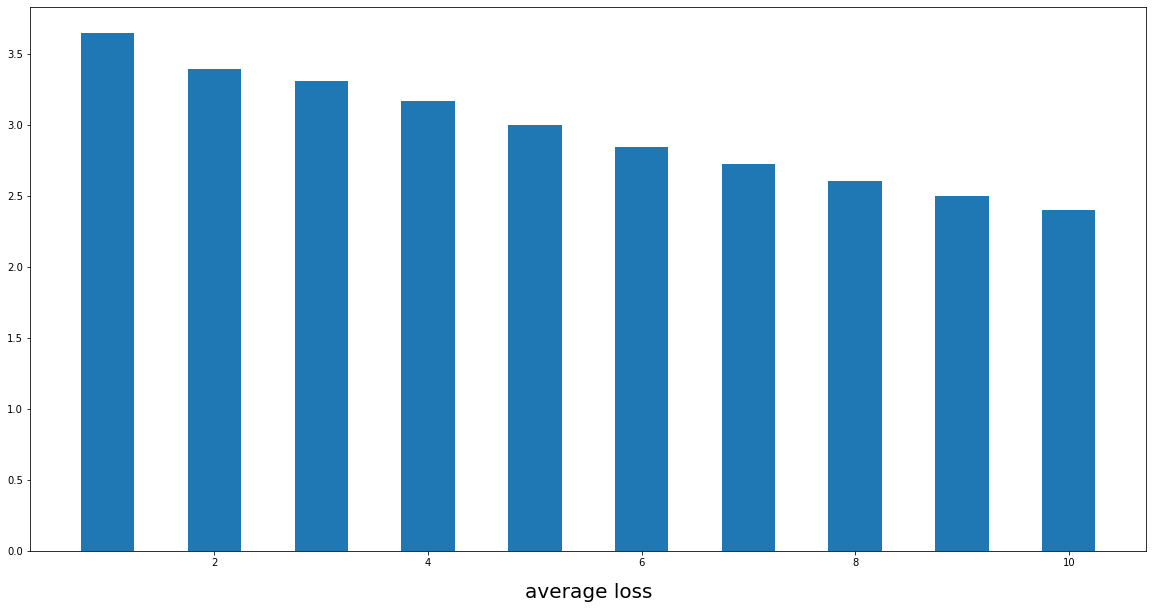

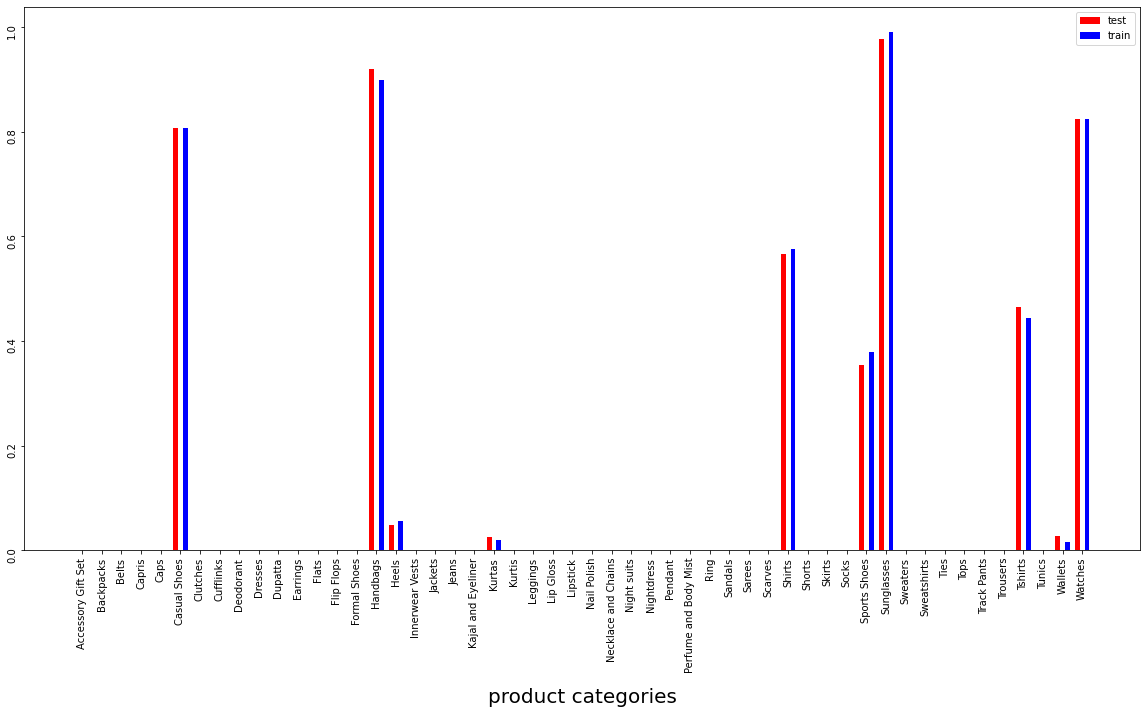

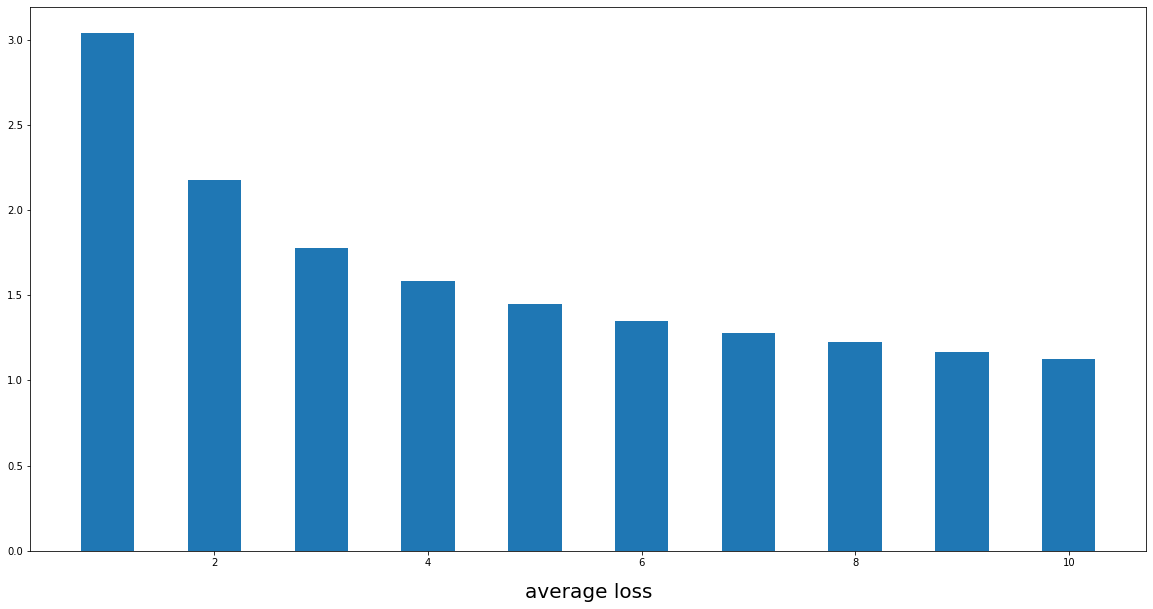

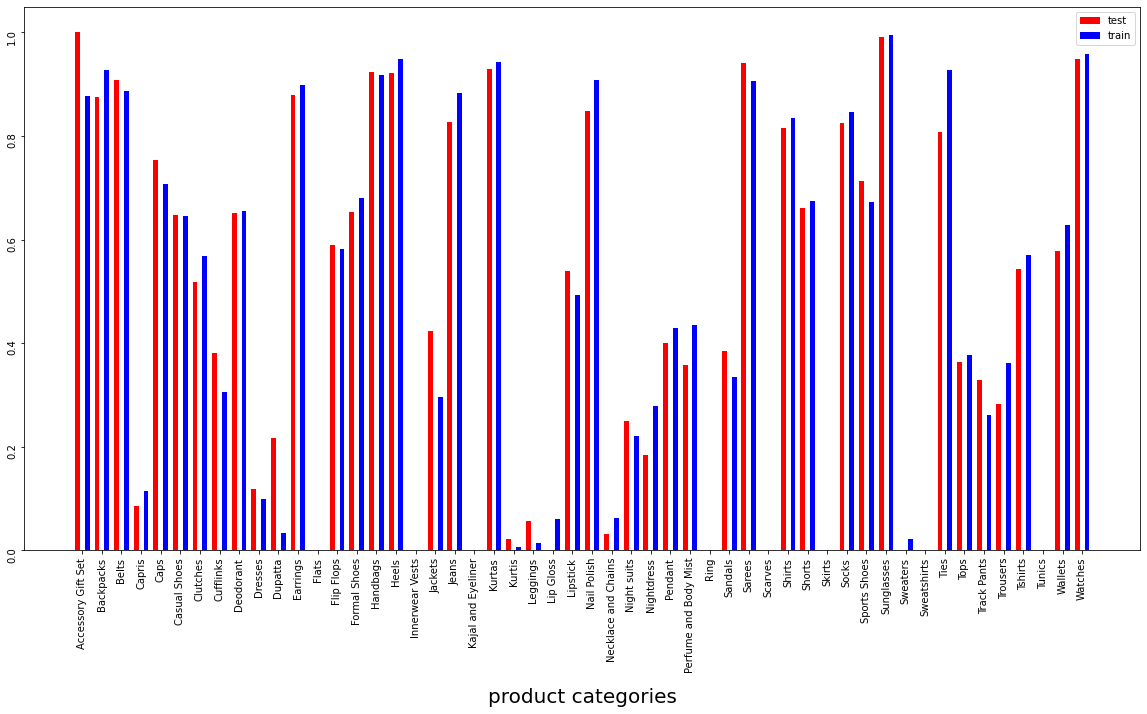

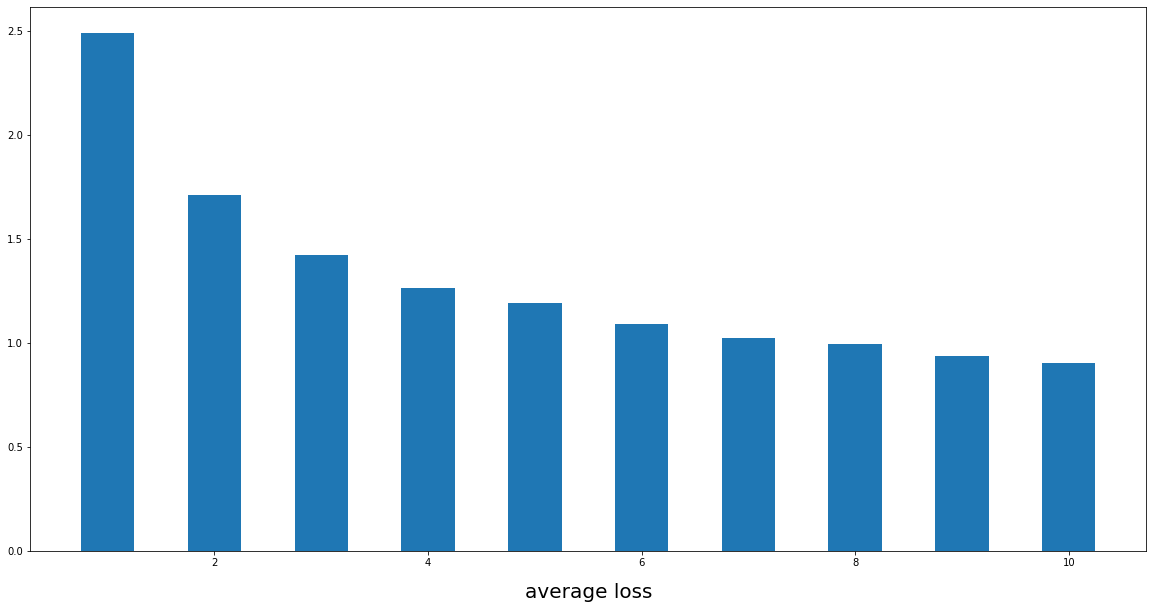

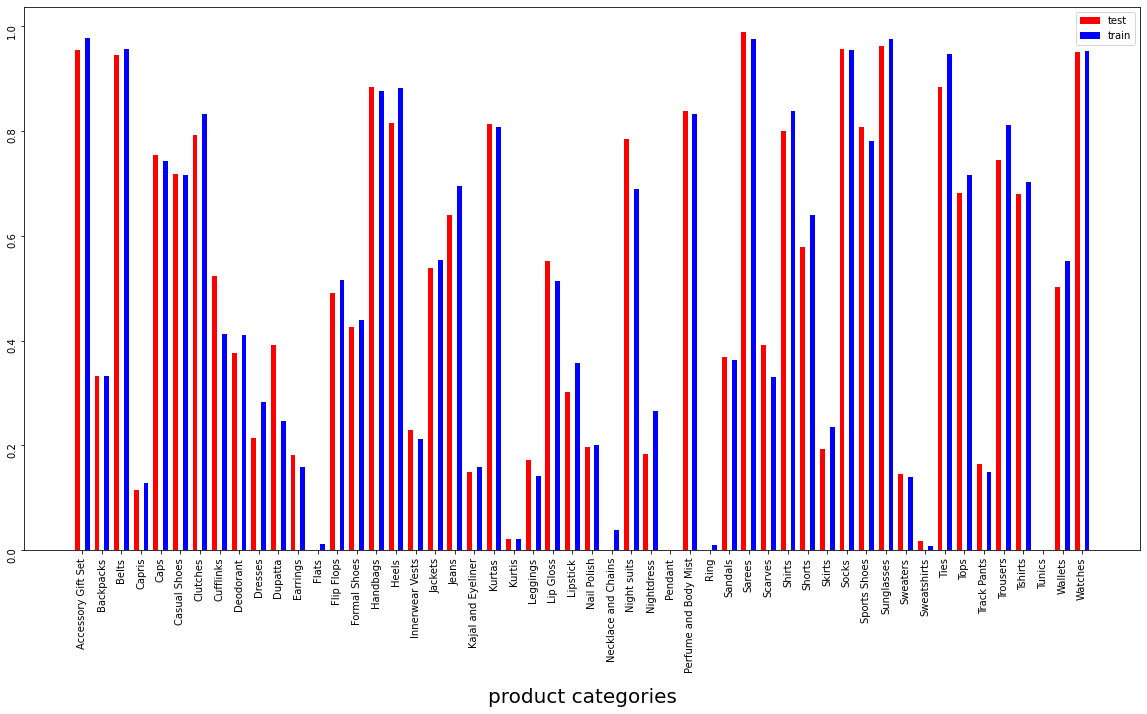

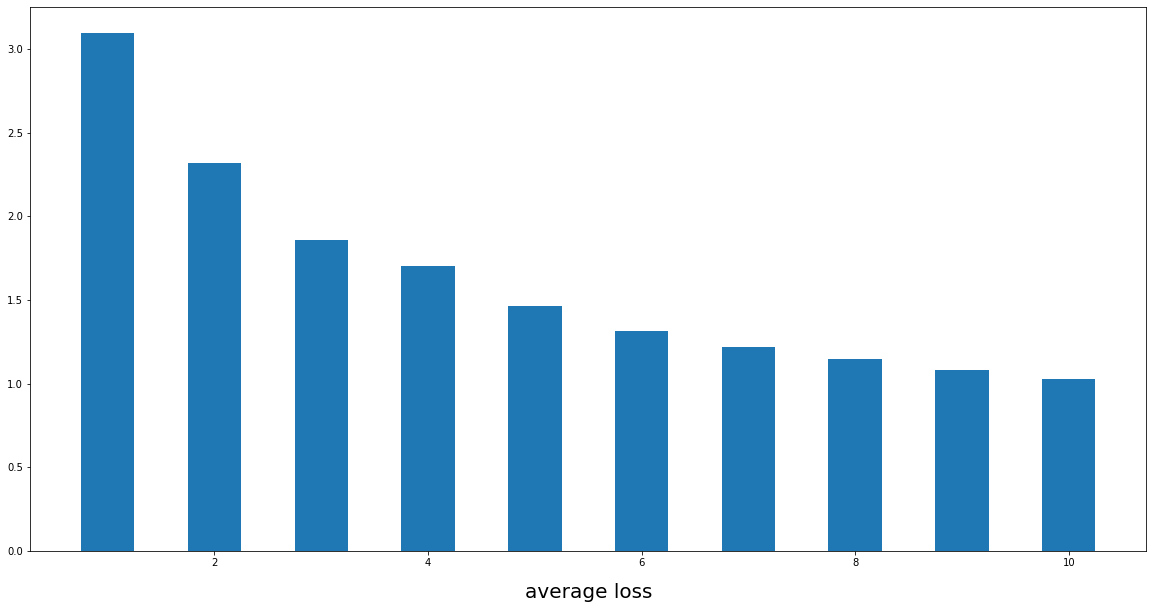

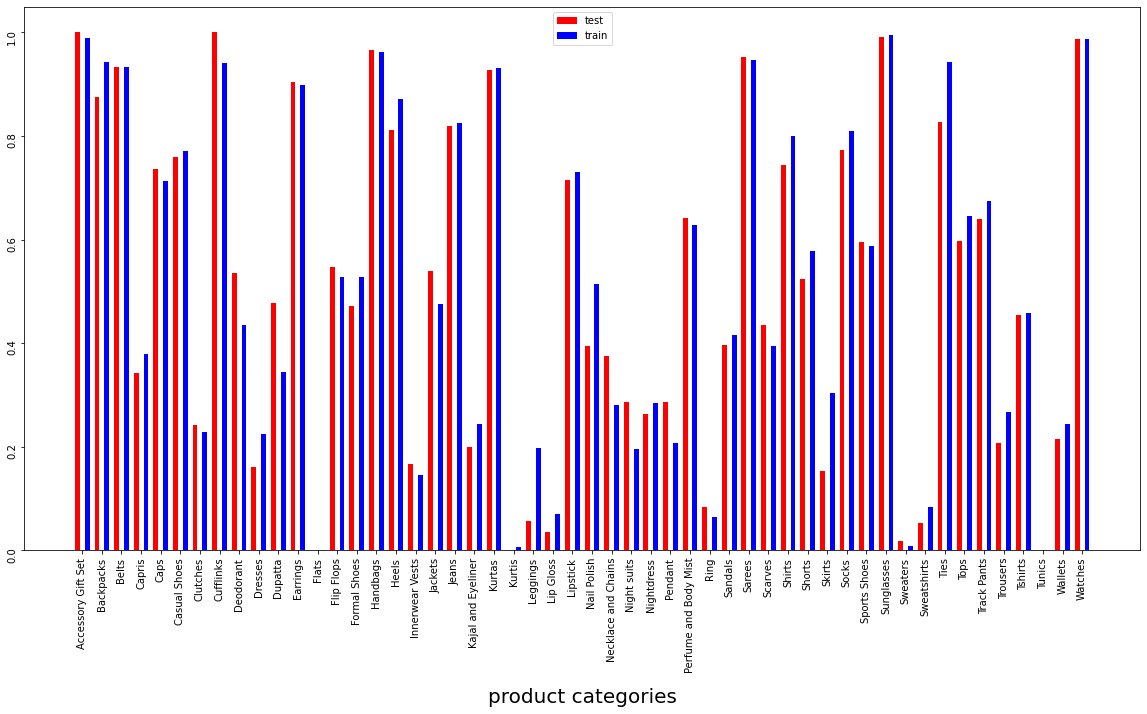

In [ ]:
learning_rates = [
    0.001,
    0.01,
    0.05,
    0.1,
]

for l in learning_rates:
    evaluate_model(
        model_config=best_layer_config,
        learning_rate=l
    )


As seen above the best learning rate of 0.05 as a little bit better than others.

By using very large learning rate, out weight would jump in bigger step and we would never reach the minimum. On the other hand by using smaller learning rates, we need more time to get to the minimum resulting in longer learning phase.

In [ ]:
best_learning_rate = 0.05

# Part 7

Now let the effect of batch size on the model:

epoch 1, train_loss: 2.489, time elapsed: 22.037914 seconds
epoch 2, train_loss: 1.701, time elapsed: 21.558451 seconds
epoch 3, train_loss: 1.412, time elapsed: 21.492895 seconds
epoch 4, train_loss: 1.263, time elapsed: 21.600662 seconds
epoch 5, train_loss: 1.161, time elapsed: 21.580566 seconds
epoch 6, train_loss: 1.095, time elapsed: 21.54191 seconds
epoch 7, train_loss: 1.020, time elapsed: 21.654568 seconds
epoch 8, train_loss: 0.987, time elapsed: 21.645215 seconds
epoch 9, train_loss: 0.946, time elapsed: 21.651658 seconds
epoch 10, train_loss: 0.902, time elapsed: 22.160436 seconds
total training time: 3.615 minutes
Accuracy: 70.36241610738254%
Accuracy: 72.1131581596698%
epoch 1, train_loss: 2.502, time elapsed: 21.716235 seconds
epoch 2, train_loss: 1.695, time elapsed: 21.628208 seconds
epoch 3, train_loss: 1.411, time elapsed: 21.60336 seconds
epoch 4, train_loss: 1.260, time elapsed: 21.599781 seconds
epoch 5, train_loss: 1.174, time elapsed: 21.649051 seconds
epoch 6, 

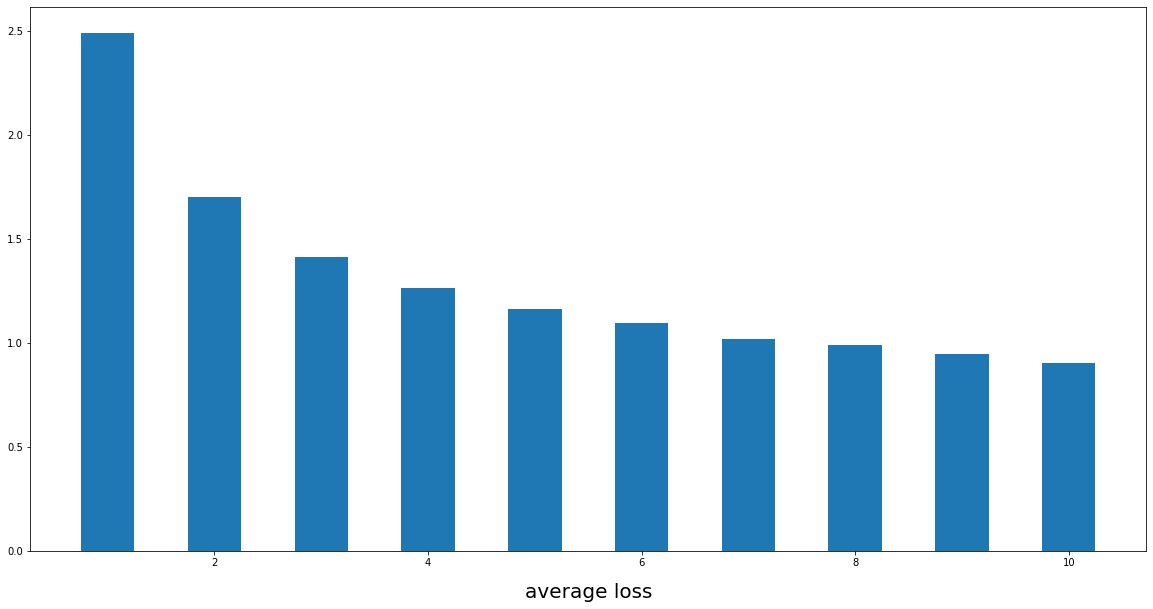

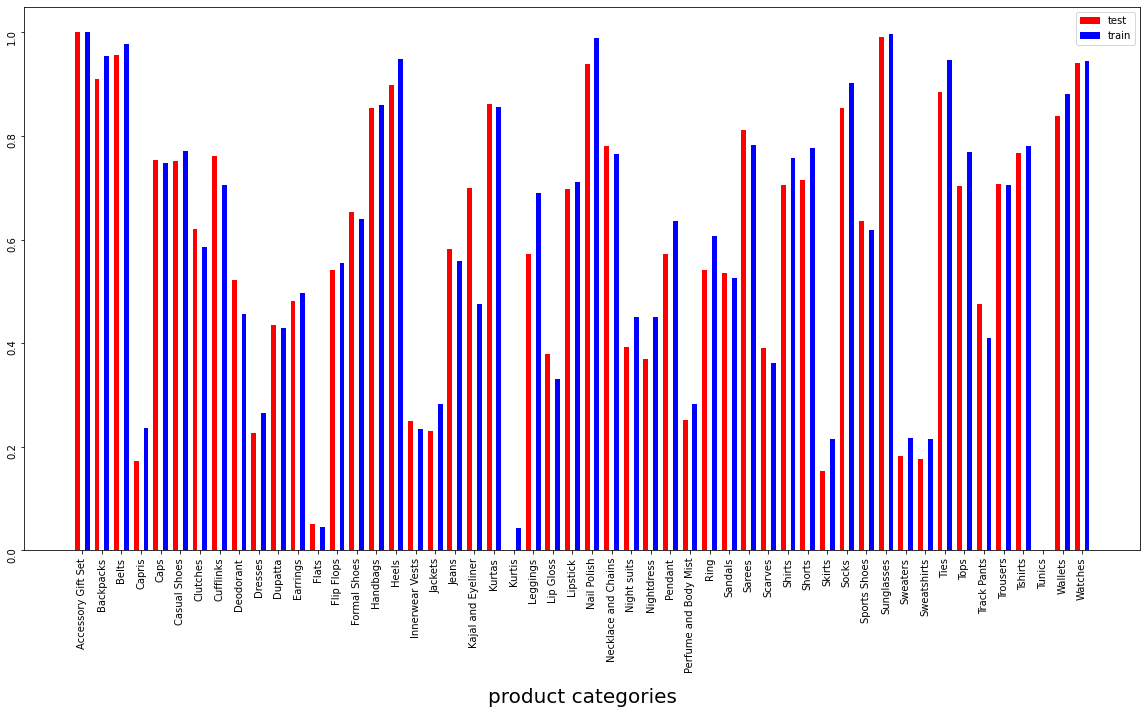

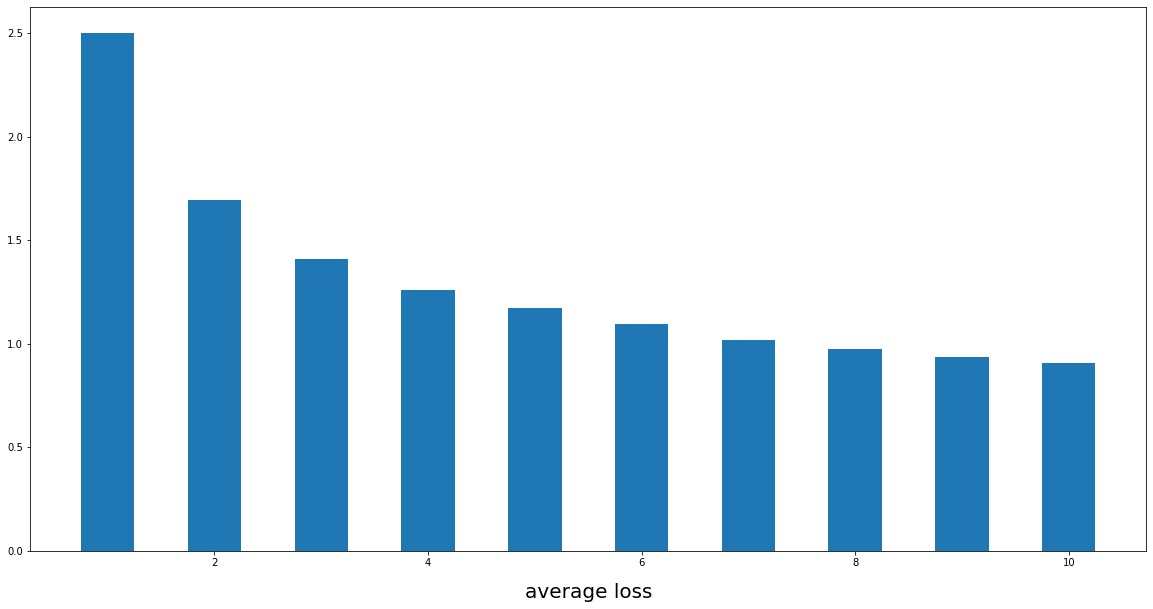

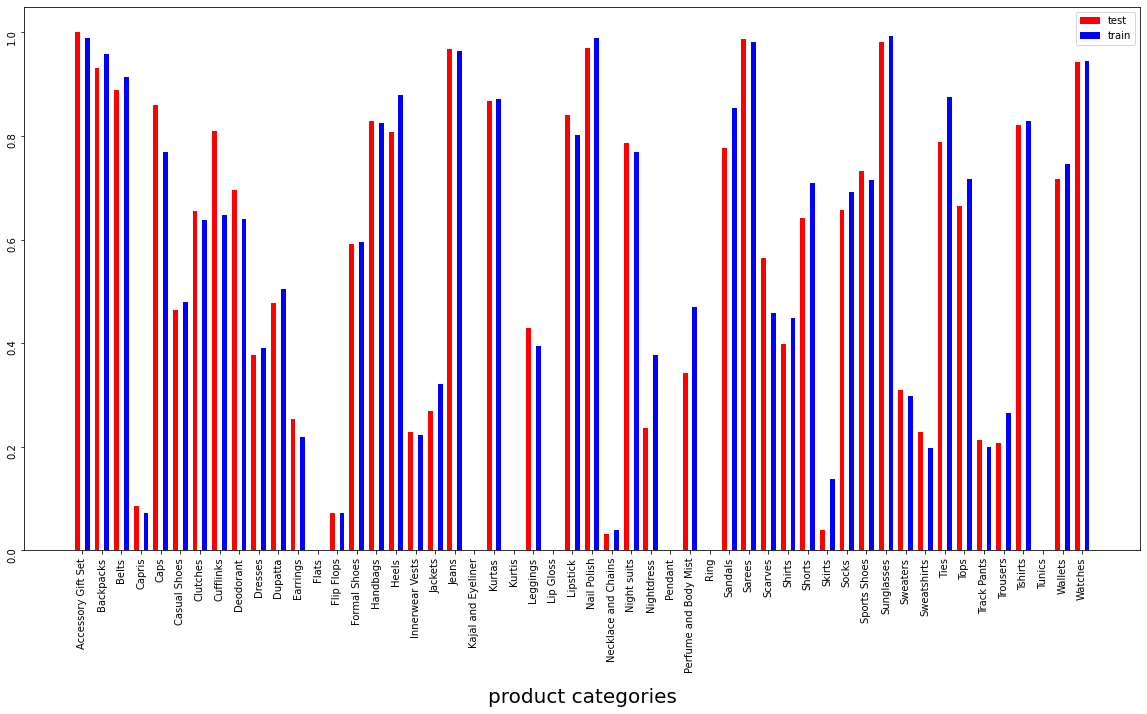

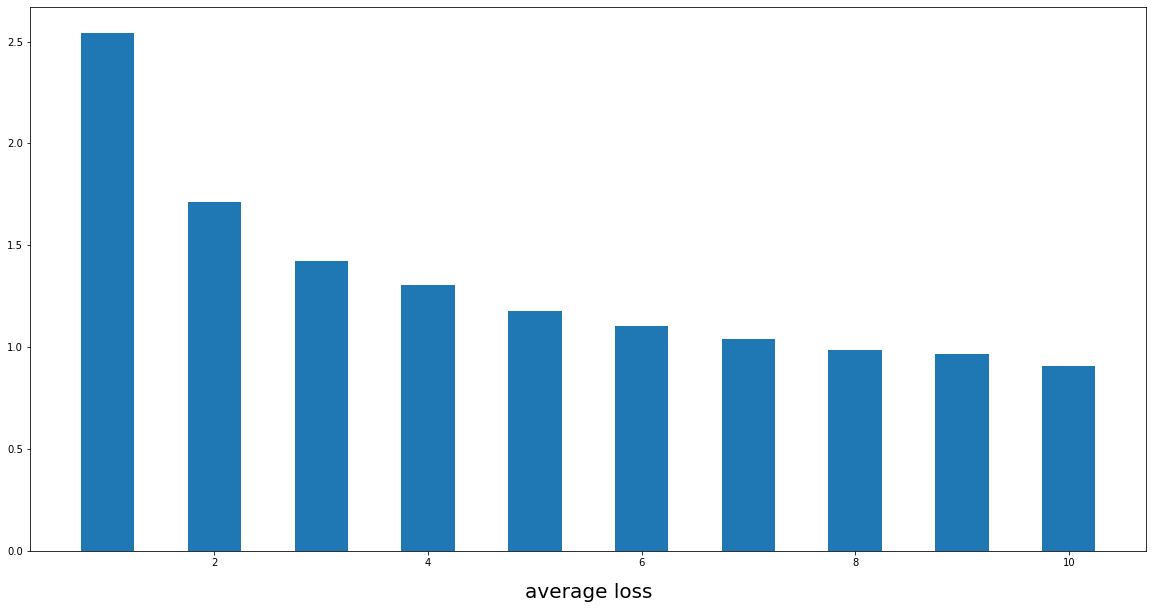

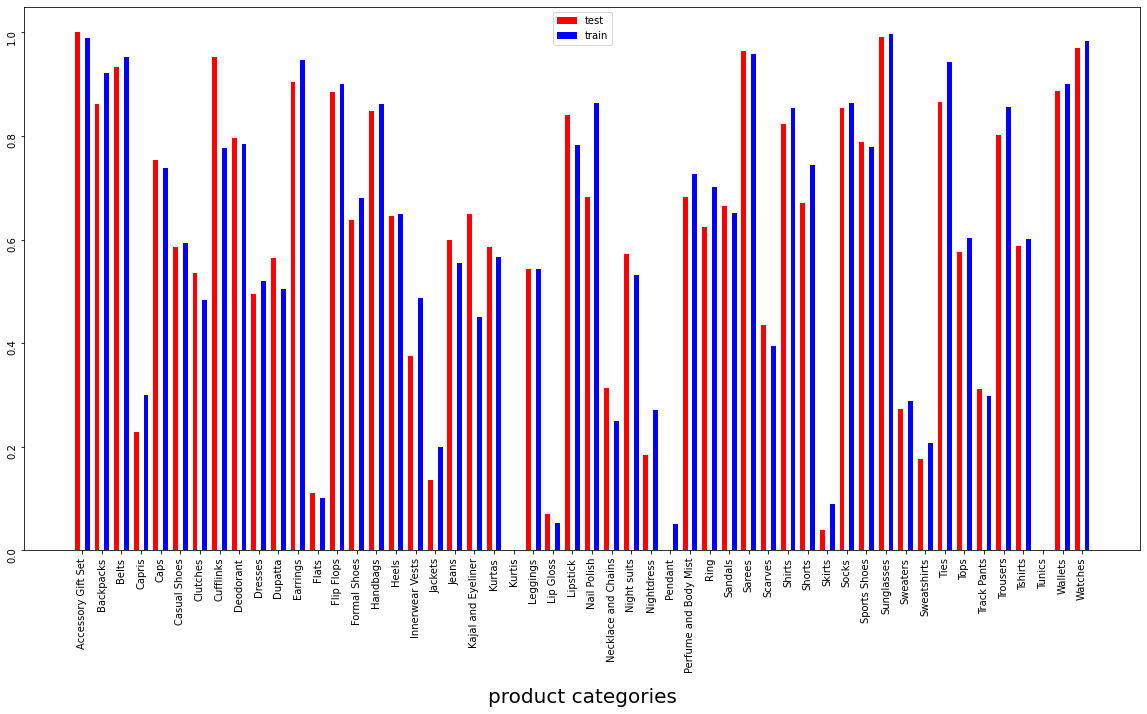

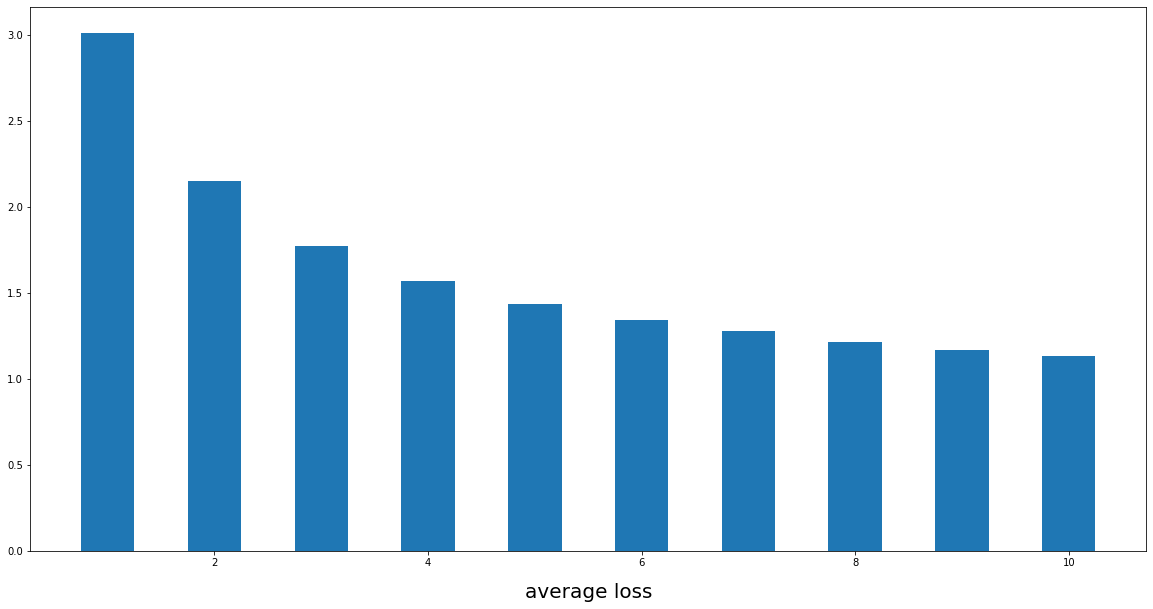

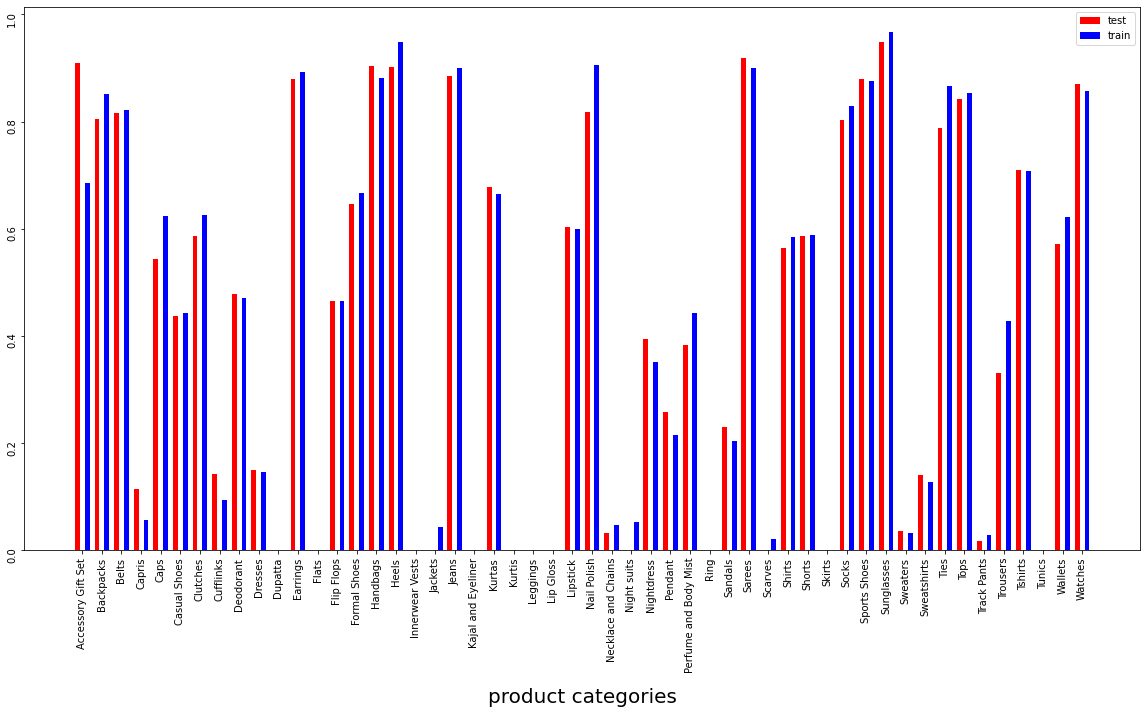

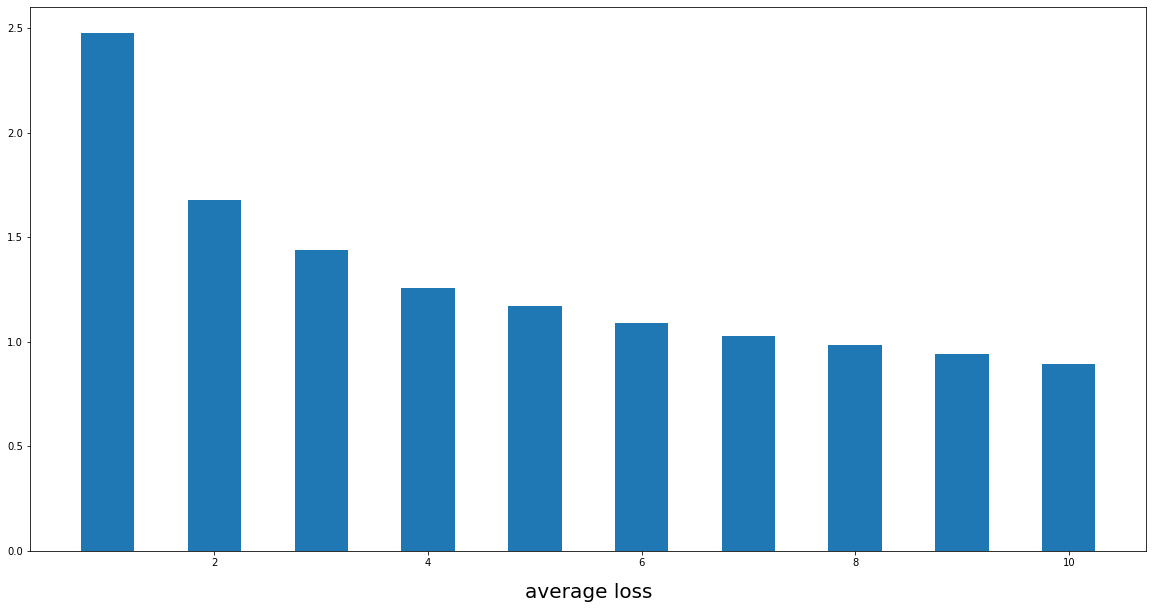

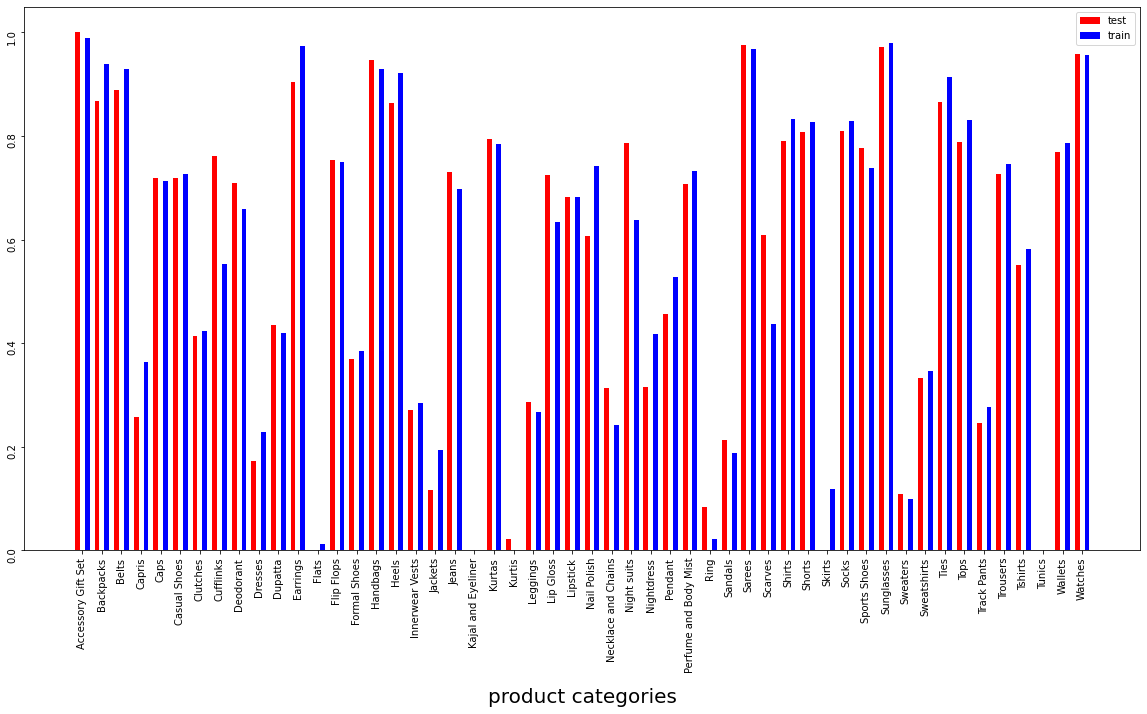

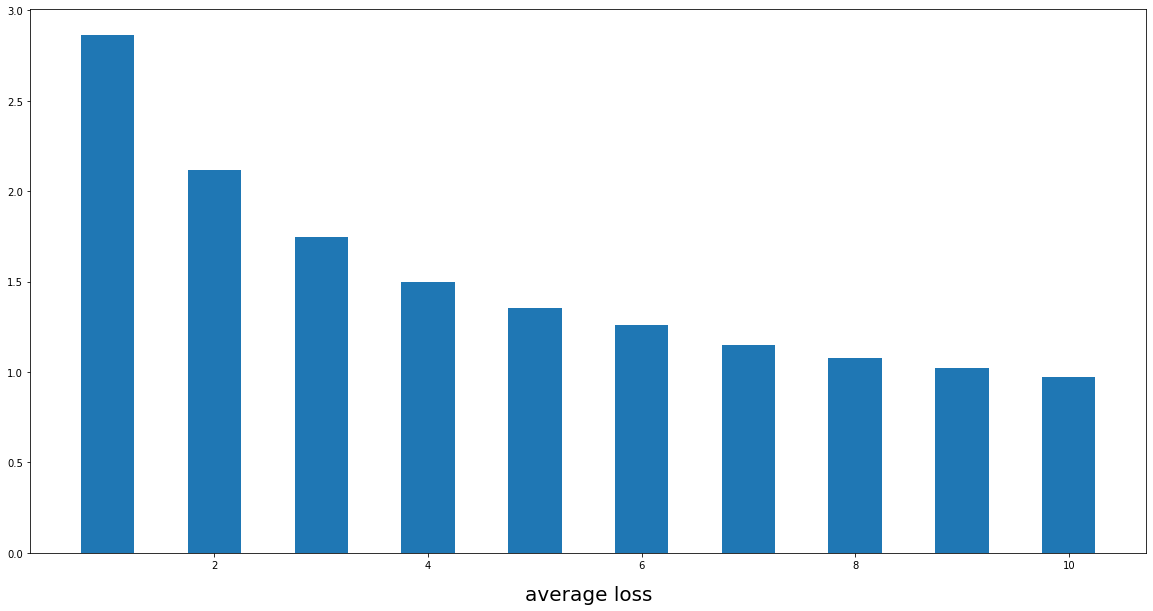

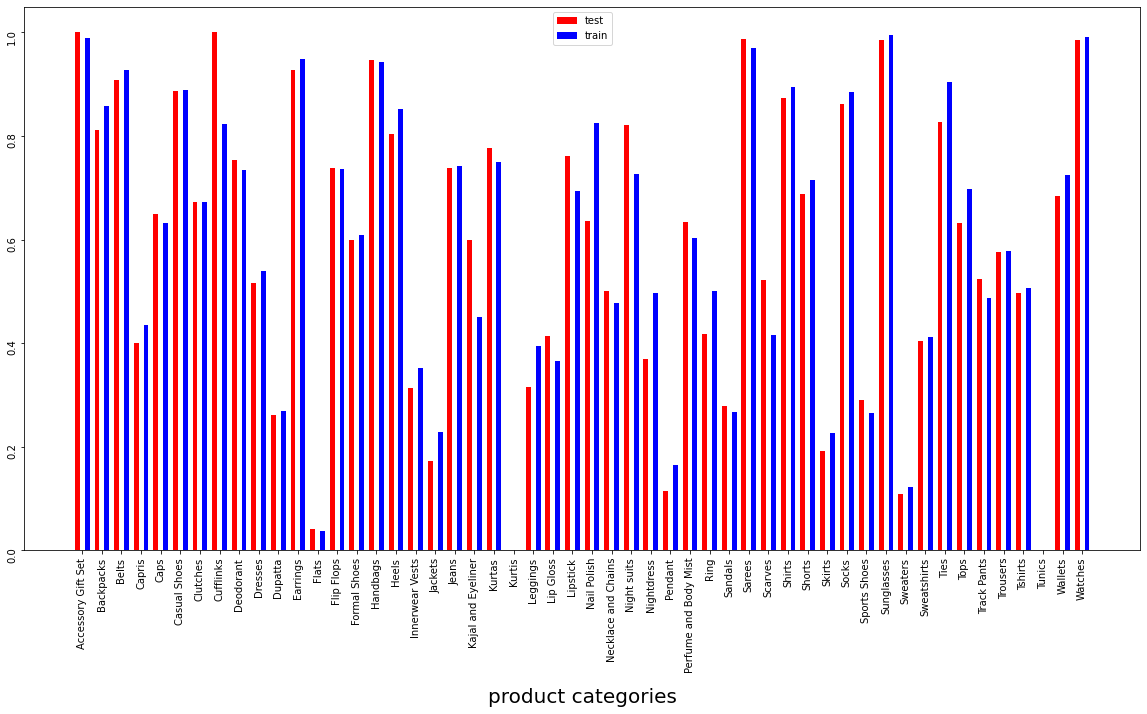

In [ ]:
batch_sizes = [
    32,
    64,
    128,
]

for b in batch_sizes:
    evaluate_model(
        model_config=best_layer_config,
        learning_rate=best_learning_rate,
        batch_size=b
    )

learning_rates = [
    0.01,
    0.05,
    0.1,
]

for l in learning_rates:
    evaluate_model(
        model_config=best_layer_config,
        learning_rate=l,
        batch_size=128
    )

Batch size can affect the time of learning and accuracy, the higher the batch size is, the more time we need for learning. However, if we use smaller batch sizes we would get stuck in local minimums and never rich the optimum weights in the model.

With smaller batch sizes, the learning rate must be small too, as each image can have more effect on the model. But with bigger batch sizes we can have bigger learning rates as we have bigger set of images resulting in less noise.

# Part 8

In this part we will see the result of changing the momentum:

epoch 1, train_loss: 2.506, time elapsed: 21.533339 seconds
epoch 2, train_loss: 1.697, time elapsed: 21.482083 seconds
epoch 3, train_loss: 1.421, time elapsed: 21.86139 seconds
epoch 4, train_loss: 1.272, time elapsed: 21.573048 seconds
epoch 5, train_loss: 1.158, time elapsed: 21.587028 seconds
epoch 6, train_loss: 1.089, time elapsed: 21.581162 seconds
epoch 7, train_loss: 1.029, time elapsed: 21.608909 seconds
epoch 8, train_loss: 0.987, time elapsed: 21.681578 seconds
epoch 9, train_loss: 0.931, time elapsed: 21.695827 seconds
epoch 10, train_loss: 0.900, time elapsed: 21.705651 seconds
total training time: 3.605 minutes
Accuracy: 66.57718120805369%
Accuracy: 67.44186046511628%
epoch 1, train_loss: 2.271, time elapsed: 21.608097 seconds
epoch 2, train_loss: 1.561, time elapsed: 21.555245 seconds
epoch 3, train_loss: 1.320, time elapsed: 21.665206 seconds
epoch 4, train_loss: 1.214, time elapsed: 21.593033 seconds
epoch 5, train_loss: 1.105, time elapsed: 21.538353 seconds
epoch 6

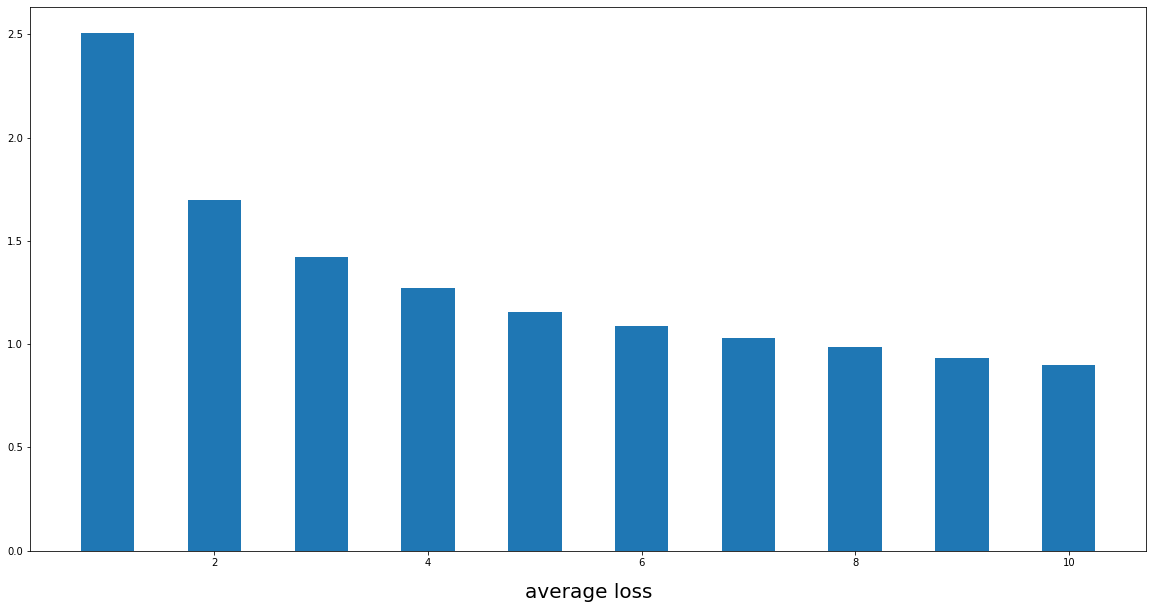

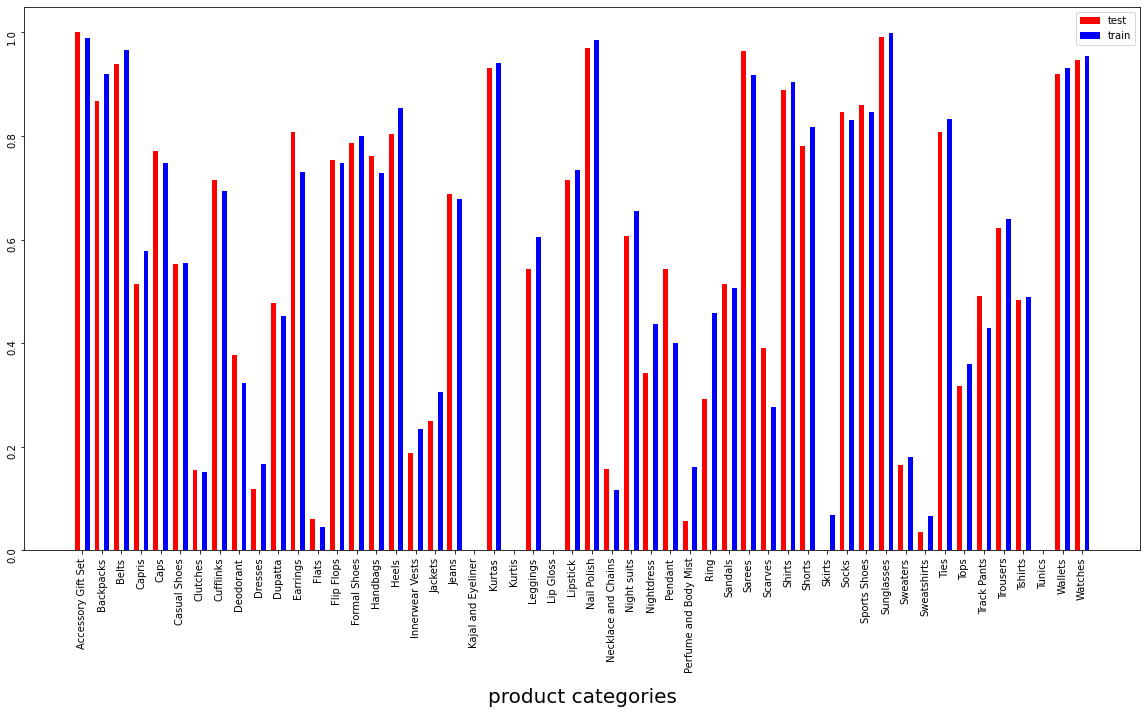

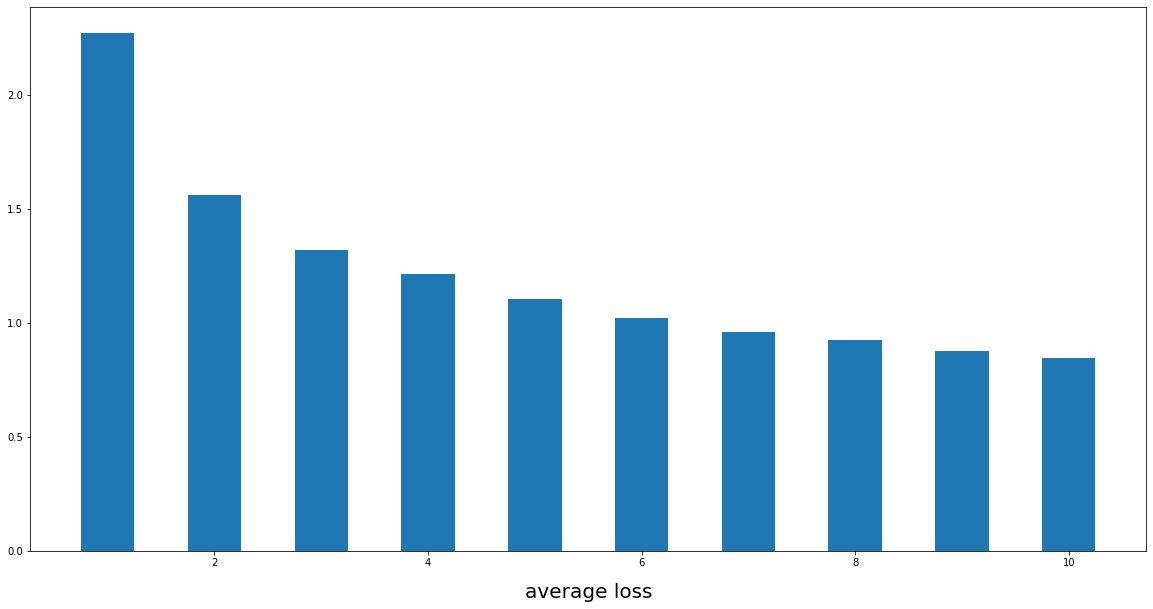

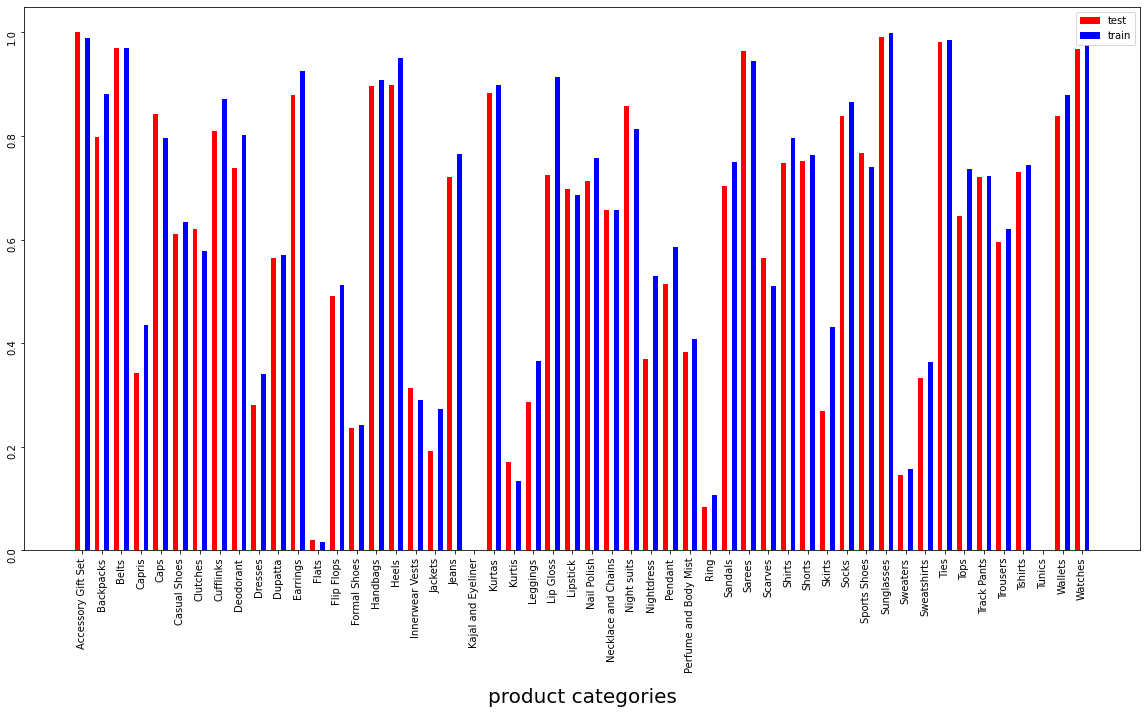

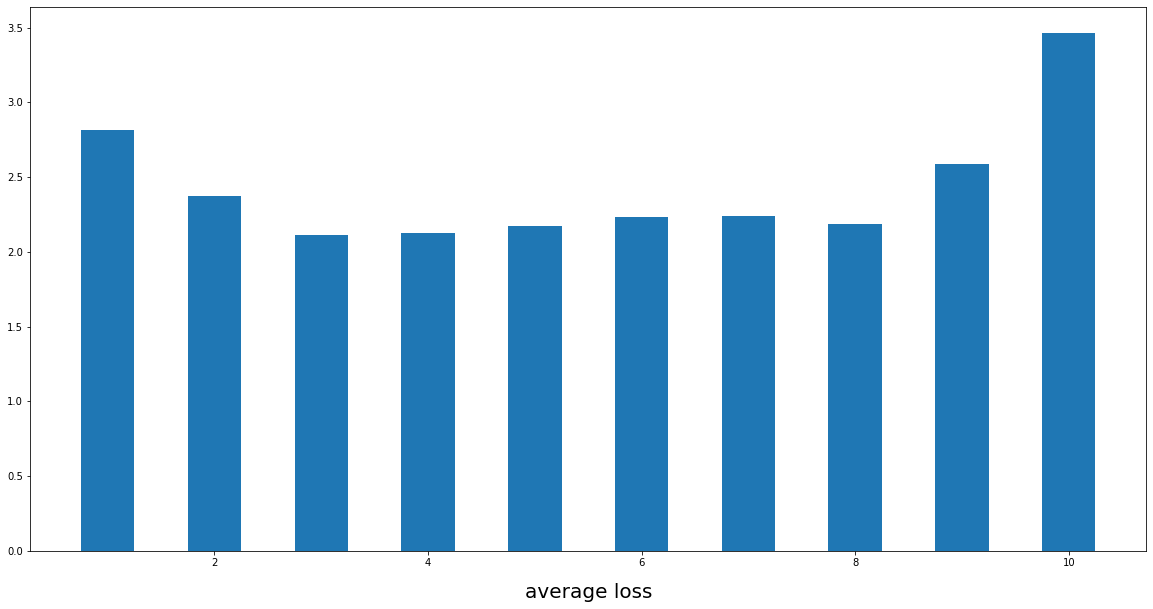

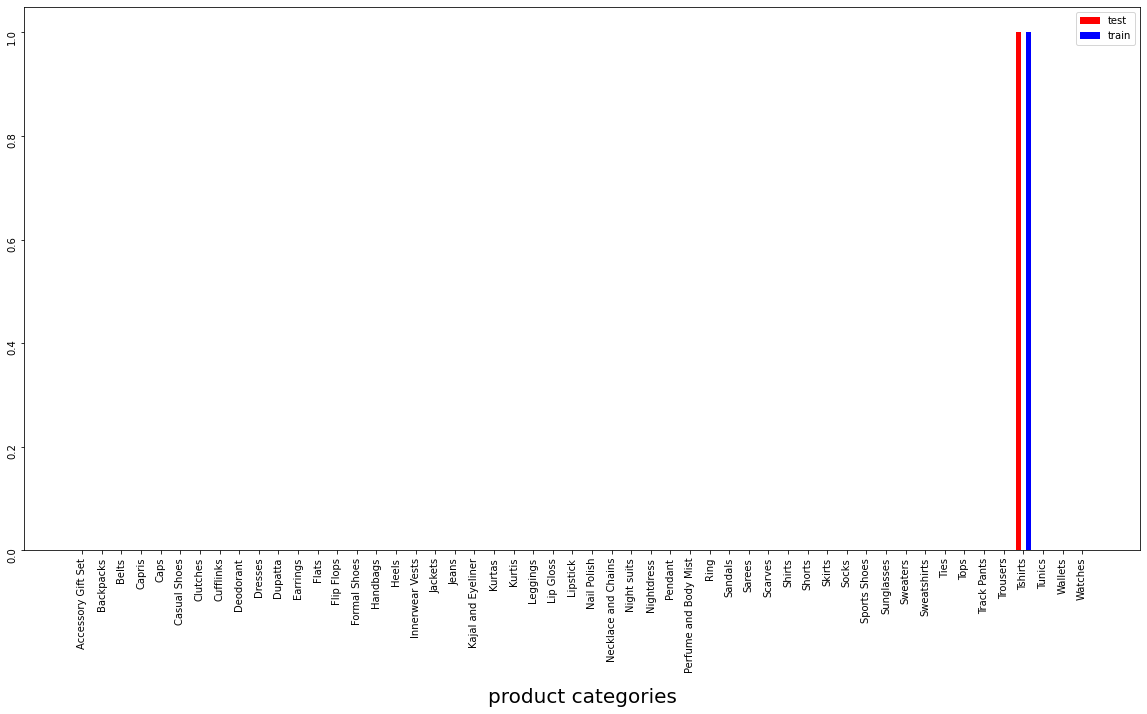

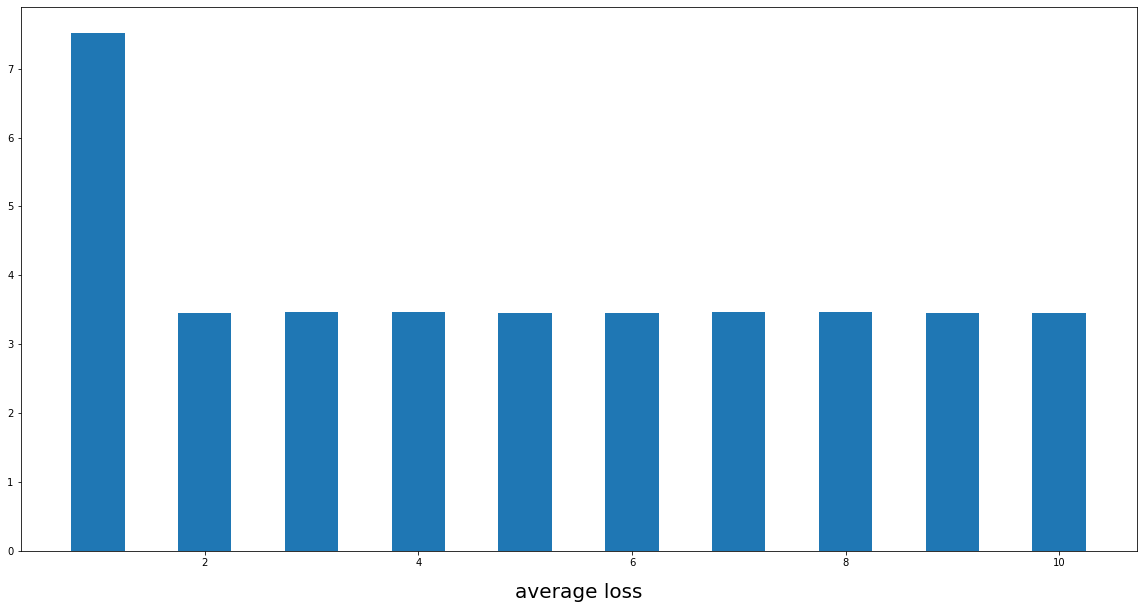

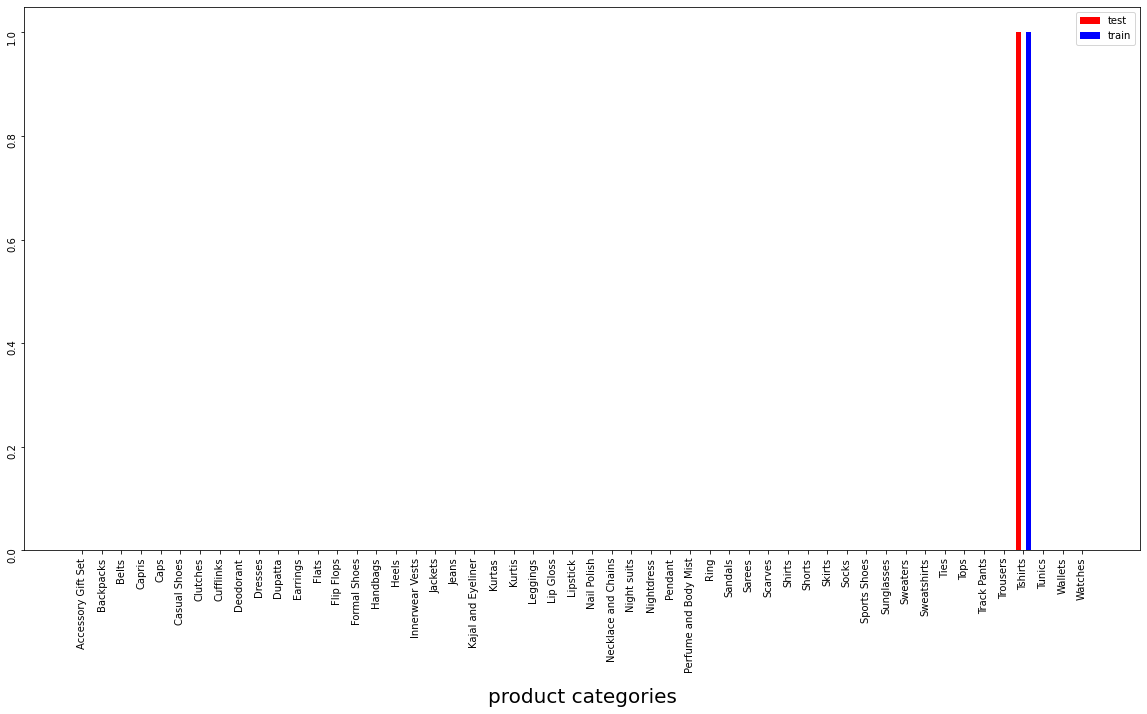

In [ ]:
momentums = [
    0.1,        
    0.5,
    0.9,
    0.98,
]

for m in momentums:
    evaluate_model(
        model_config=best_layer_config,
        learning_rate=best_learning_rate,
        momentum=m,
    )

The most accurate momentum is 0.5.
Momentum is a coefficient of effect of earlier weights on the current weight.

$$ V_t = \beta \cdot V_{t−1}+(1 − \beta) \cdot S_t $$

Where $\beta$ is the momentum and is in range of [0, 1].

With Stochastic Gradient Descent we don’t compute the exact derivate of our loss function. Instead, we’re estimating it on a small batch. Which means we’re not always going in the optimal direction, because our derivatives are ‘noisy’. So, exponentially weighed averages can provide us a better estimate which is closer to the actual derivate than our noisy calculations. This is one reason why momentum might work better than classic SGD. ([Ref](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d))

Not always higher momentum gives us better results, i.e. if we choose 1 for momentum,  at first when weights have a lot of noise would have more effects than the changes and leads us to wrong weights.

In [ ]:
best_momentum = 0.5

# Part 9

Now lets check different numbers for epochs:

epoch 1, train_loss: 2.480, time elapsed: 20.952848 seconds
epoch 2, train_loss: 1.637, time elapsed: 20.703052 seconds
epoch 3, train_loss: 1.362, time elapsed: 20.740538 seconds
epoch 4, train_loss: 1.225, time elapsed: 20.797955 seconds
epoch 5, train_loss: 1.130, time elapsed: 20.829978 seconds
epoch 6, train_loss: 1.043, time elapsed: 20.750235 seconds
epoch 7, train_loss: 0.988, time elapsed: 20.728606 seconds
epoch 8, train_loss: 0.940, time elapsed: 20.772658 seconds
epoch 9, train_loss: 0.898, time elapsed: 20.630468 seconds
epoch 10, train_loss: 0.871, time elapsed: 20.645442 seconds
total training time: 3.459 minutes
Accuracy: 71.73154362416108%
Accuracy: 72.91519849659385%
epoch 1, train_loss: 2.344, time elapsed: 20.681502 seconds
epoch 2, train_loss: 1.551, time elapsed: 20.816113 seconds
epoch 3, train_loss: 1.334, time elapsed: 20.800481 seconds
epoch 4, train_loss: 1.194, time elapsed: 20.738431 seconds
epoch 5, train_loss: 1.095, time elapsed: 20.752096 seconds
epoch 

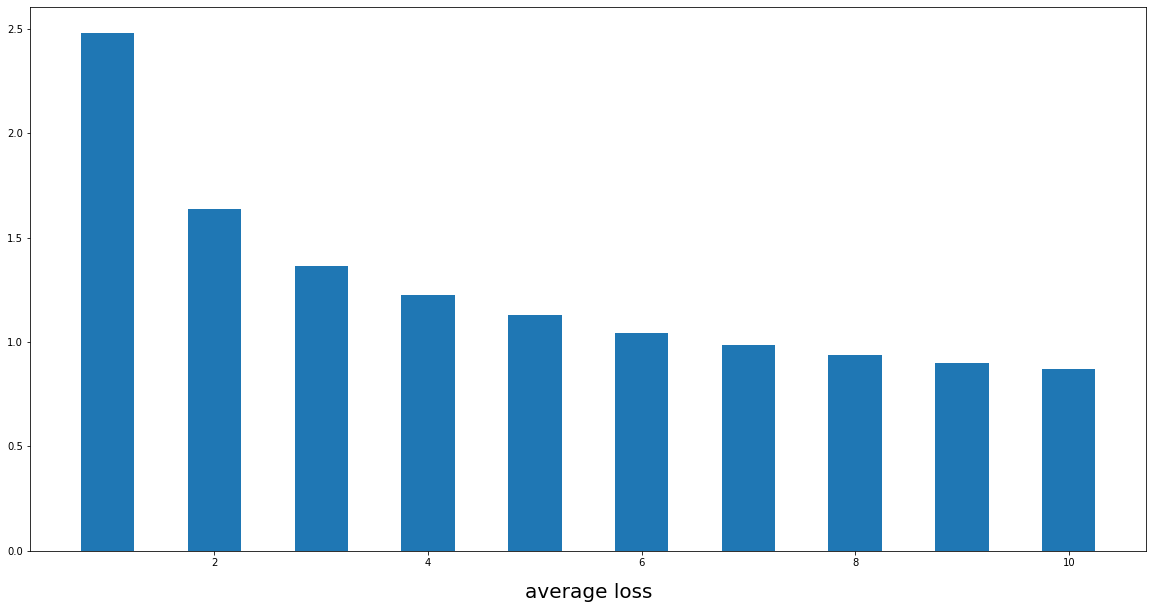

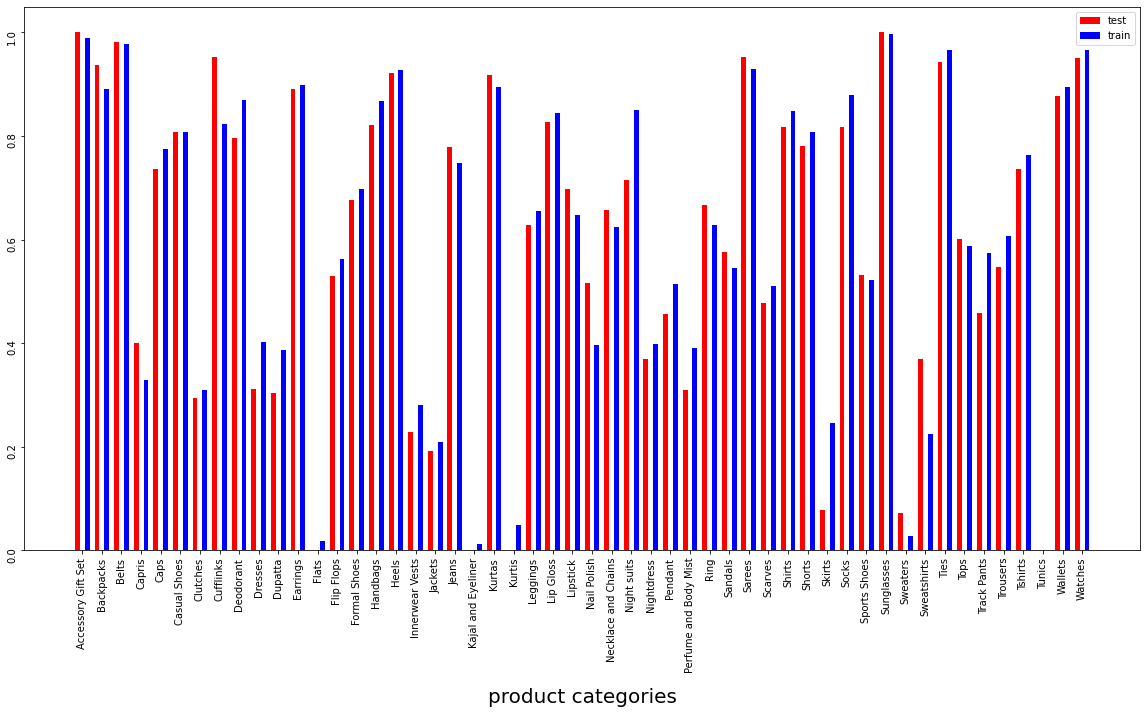

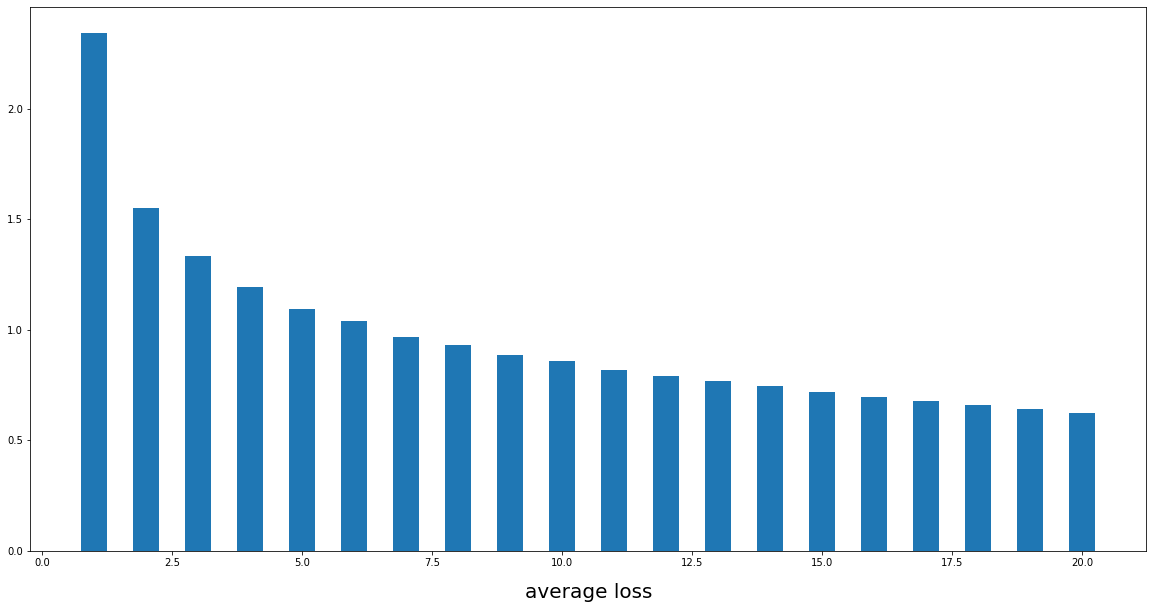

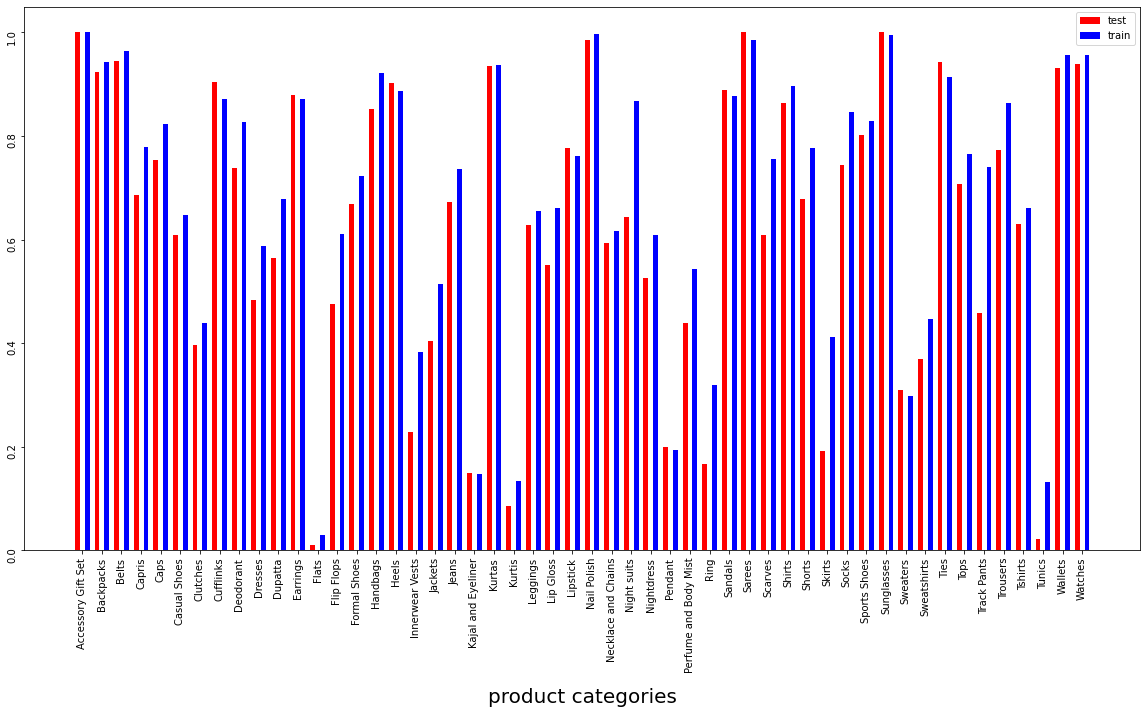

In [ ]:
numbers_of_epochs = [
    10,        
    20,
]

for n in numbers_of_epochs:
    evaluate_model(
        model_config=best_layer_config,
        learning_rate=best_learning_rate,
        momentum=best_momentum,
        epochs=n
    )

With epoch number of 20, we get moderately better results.

We need more than one epochs, because gradient descent methods (such as SGD) does usually not find the optimal parameters (weights) in one pass, they are iterative algorithms and improve in tiny steps (learning rate) and we need more than one epochs for that. However, with high number of epochs the model may get overfitted over the training set.

# Part 10

Now let's use some other activation functions instead of Relu:

epoch 1, train_loss: 2.334, time elapsed: 20.882503 seconds
epoch 2, train_loss: 1.617, time elapsed: 20.771259 seconds
epoch 3, train_loss: 1.362, time elapsed: 20.807171 seconds
epoch 4, train_loss: 1.210, time elapsed: 20.741642 seconds
epoch 5, train_loss: 1.123, time elapsed: 20.729683 seconds
epoch 6, train_loss: 1.041, time elapsed: 20.697438 seconds
epoch 7, train_loss: 0.983, time elapsed: 20.865694 seconds
epoch 8, train_loss: 0.930, time elapsed: 20.803881 seconds
epoch 9, train_loss: 0.891, time elapsed: 20.802923 seconds
epoch 10, train_loss: 0.853, time elapsed: 20.822634 seconds
total training time: 3.465 minutes
Accuracy: 69.20805369127517%
Accuracy: 70.37148897614014%
epoch 1, train_loss: 2.294, time elapsed: 20.70039 seconds
epoch 2, train_loss: 1.669, time elapsed: 20.683483 seconds
epoch 3, train_loss: 1.358, time elapsed: 20.594546 seconds
epoch 4, train_loss: 1.203, time elapsed: 20.632139 seconds
epoch 5, train_loss: 1.115, time elapsed: 20.745279 seconds
epoch 6

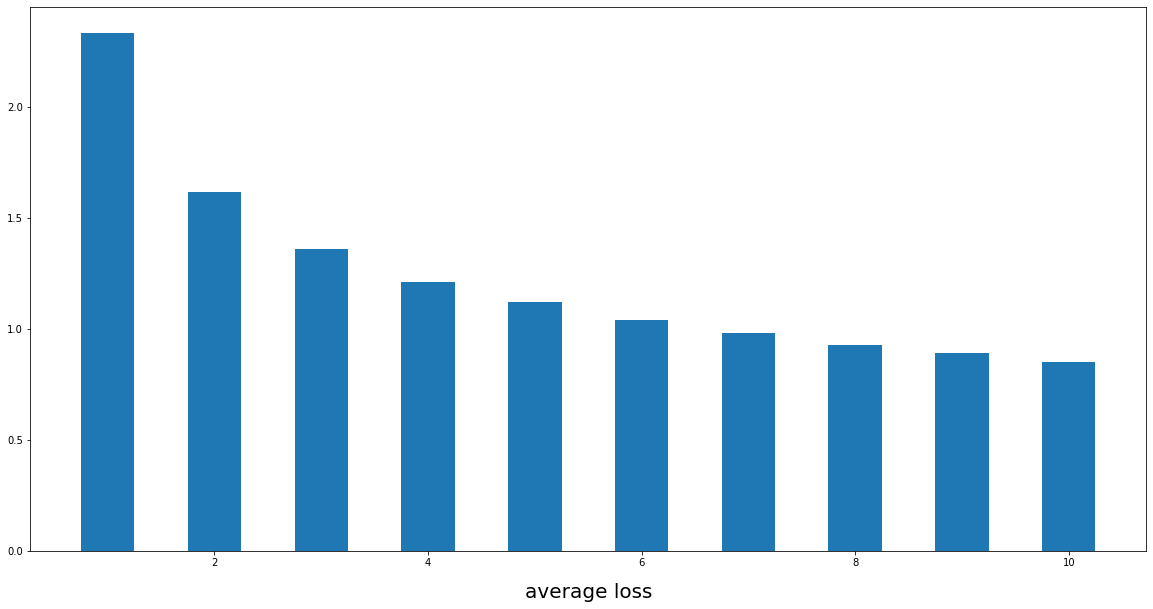

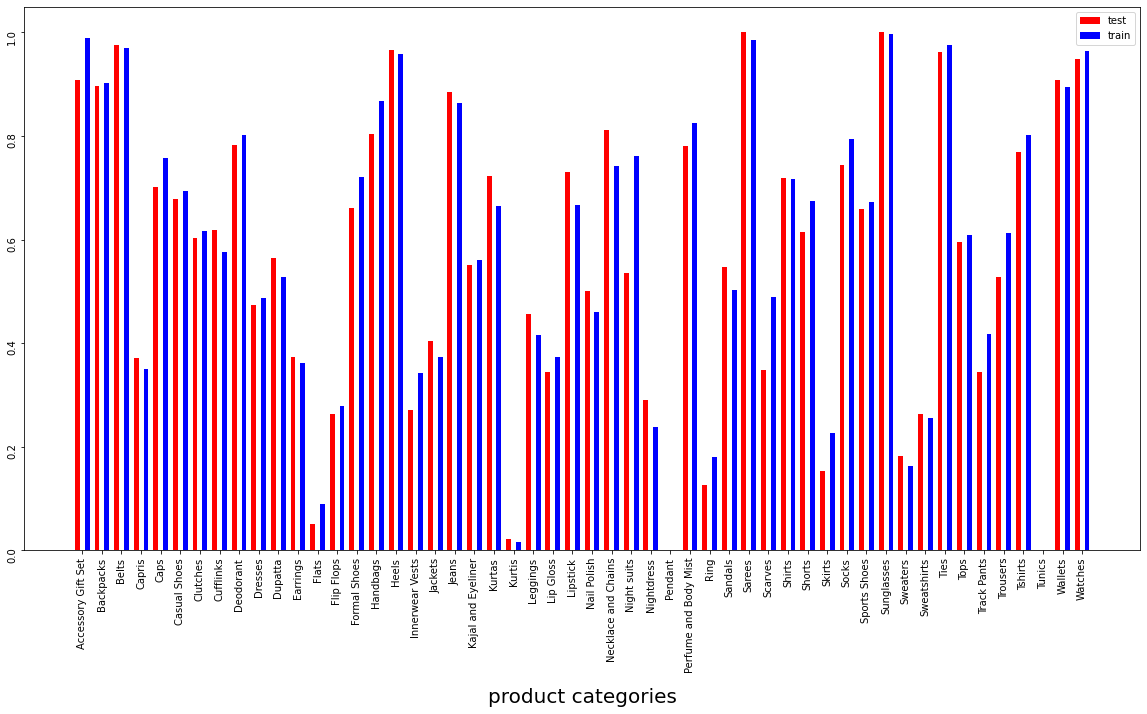

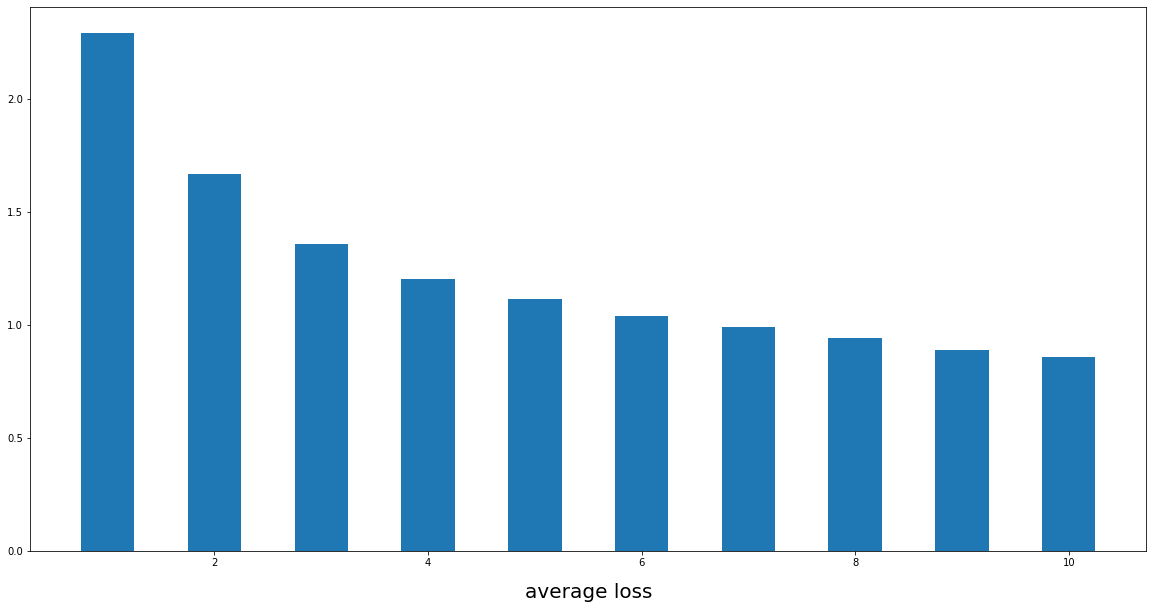

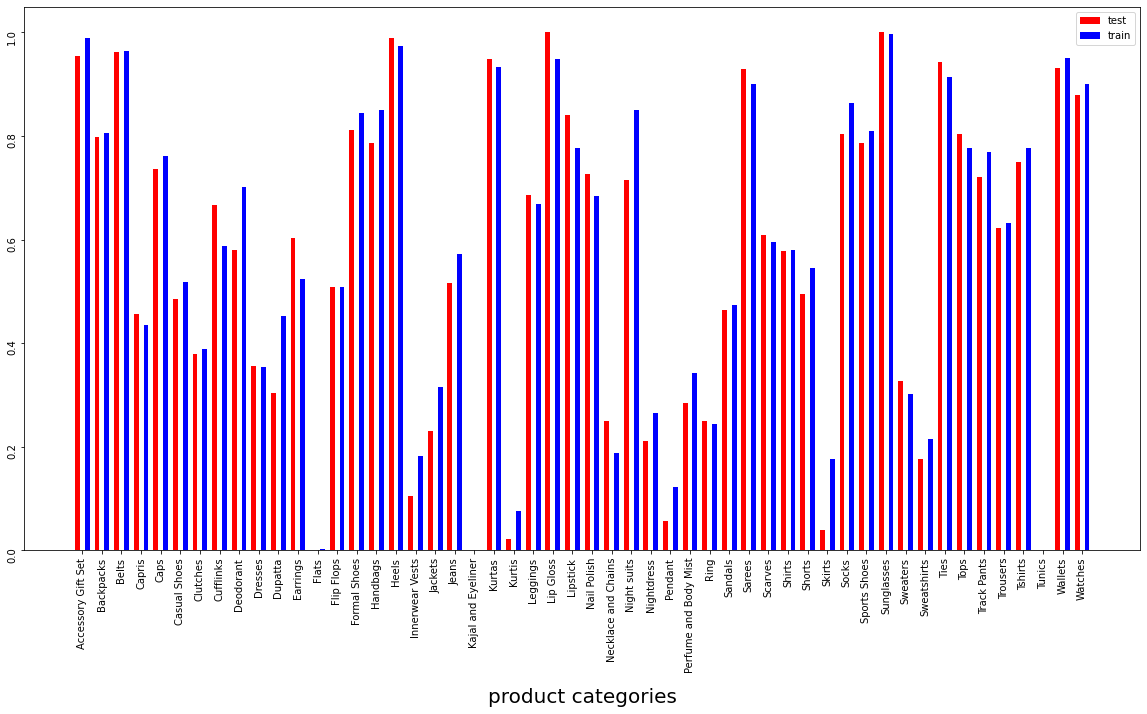

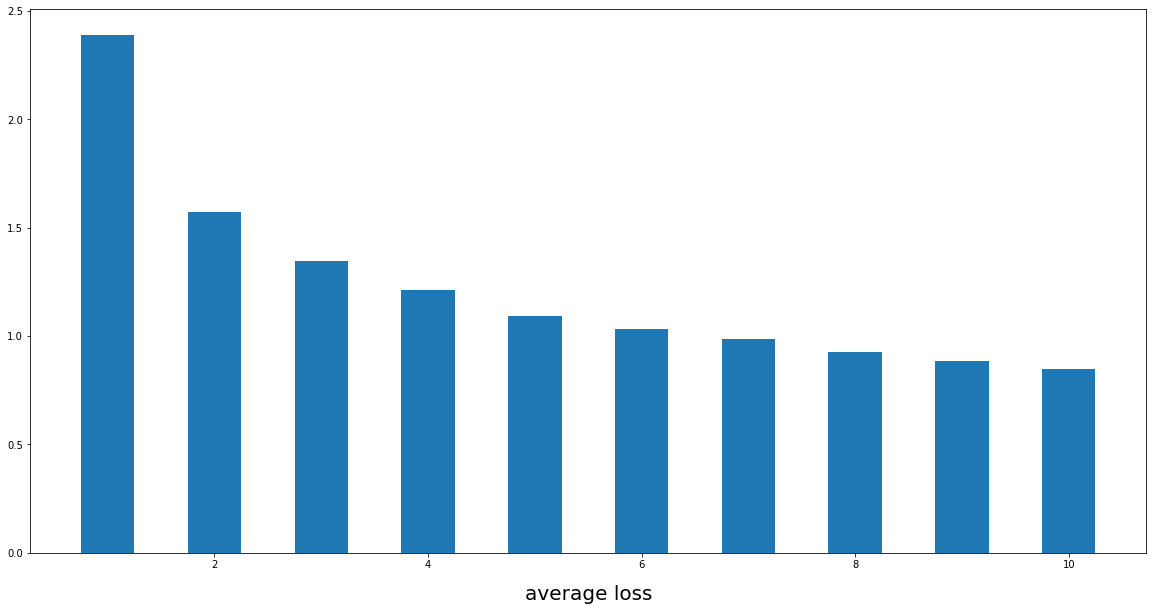

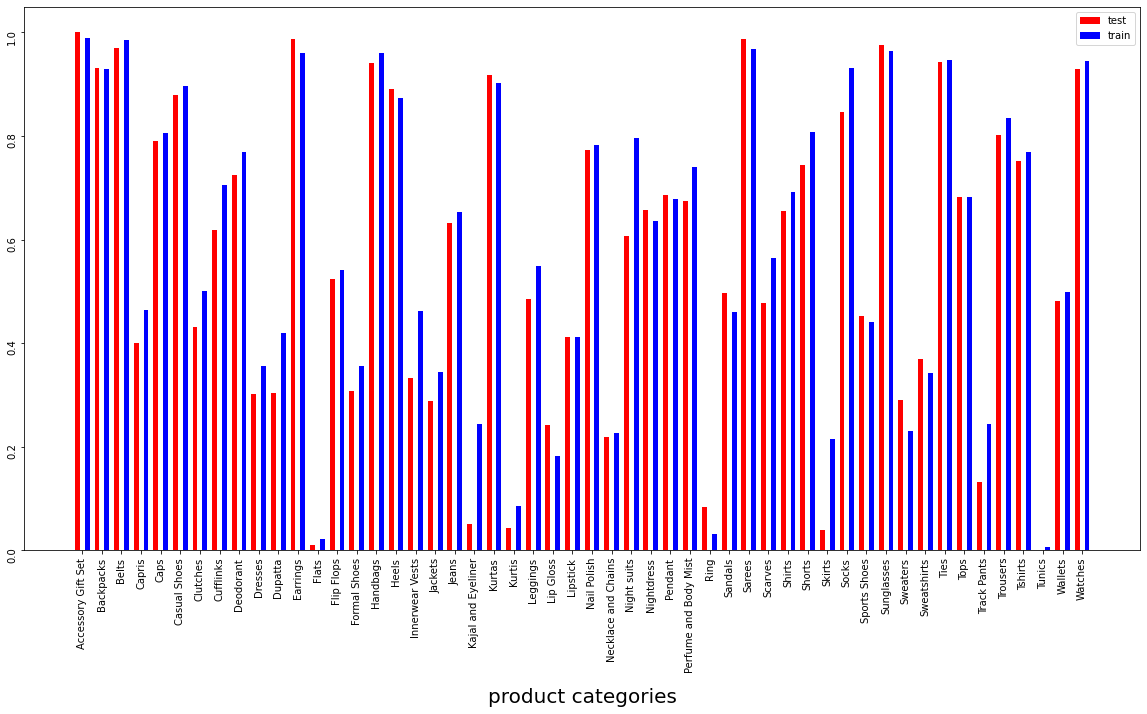

In [ ]:
activation_functions = [
    F.relu,
    F.leaky_relu,
    F.tanh,
]

for act in activation_functions:
    evaluate_model(
        model_config=best_layer_config,
        learning_rate=best_learning_rate,
        momentum=best_momentum,
        act=act
    )

tanh performs slightly better than others.
As we know relu output has a range of $[0, \inf)$, and tanh has the range of [-1, 1]. Also leaky relu has a small negative slope for numbers less than zero.
As out images are normalized between zero and one and we don't have negative numbers, nor large numbers, so there is not much difference between them in our model.

# Part 11

As the last part, let's check refularization:

epoch 1, train_loss: 2.333, time elapsed: 20.920529 seconds
epoch 2, train_loss: 1.572, time elapsed: 20.802274 seconds
epoch 3, train_loss: 1.392, time elapsed: 20.742998 seconds
epoch 4, train_loss: 1.223, time elapsed: 20.711354 seconds
epoch 5, train_loss: 1.109, time elapsed: 20.722955 seconds
epoch 6, train_loss: 1.030, time elapsed: 20.697542 seconds
epoch 7, train_loss: 0.976, time elapsed: 20.788413 seconds
epoch 8, train_loss: 0.934, time elapsed: 20.627786 seconds
epoch 9, train_loss: 0.896, time elapsed: 20.871704 seconds
epoch 10, train_loss: 0.860, time elapsed: 20.816487 seconds
total training time: 3.462 minutes
Accuracy: 66.13422818791946%
Accuracy: 66.82439008020404%
epoch 1, train_loss: 3.055, time elapsed: 22.60126 seconds
epoch 2, train_loss: 2.987, time elapsed: 22.684526 seconds
epoch 3, train_loss: 2.972, time elapsed: 22.700442 seconds
epoch 4, train_loss: 2.975, time elapsed: 22.654697 seconds
epoch 5, train_loss: 3.141, time elapsed: 22.662445 seconds
epoch 6

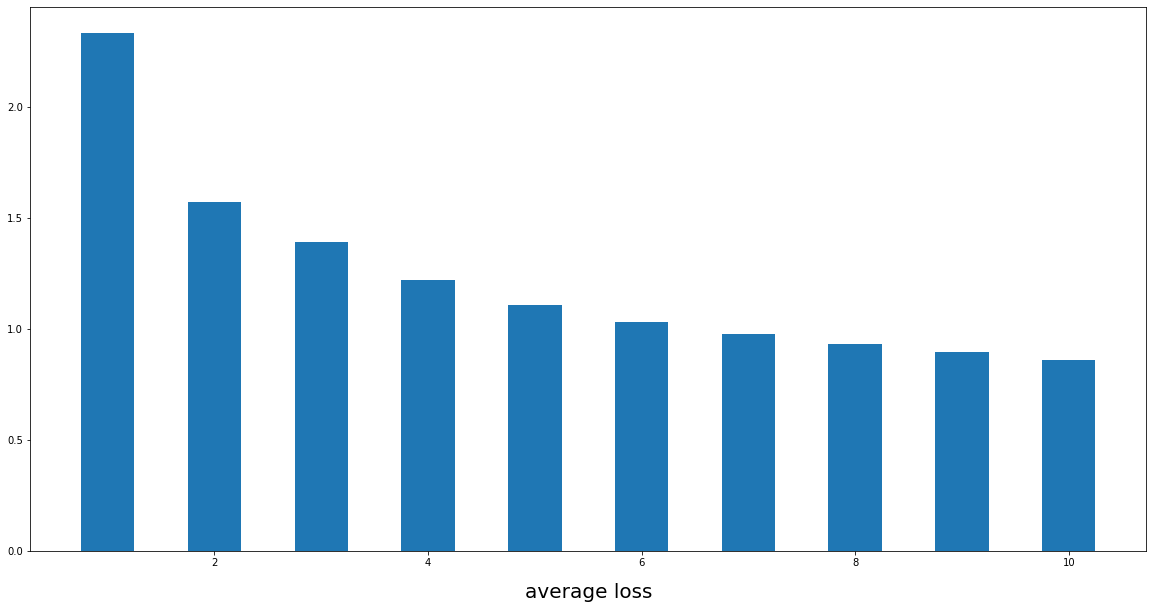

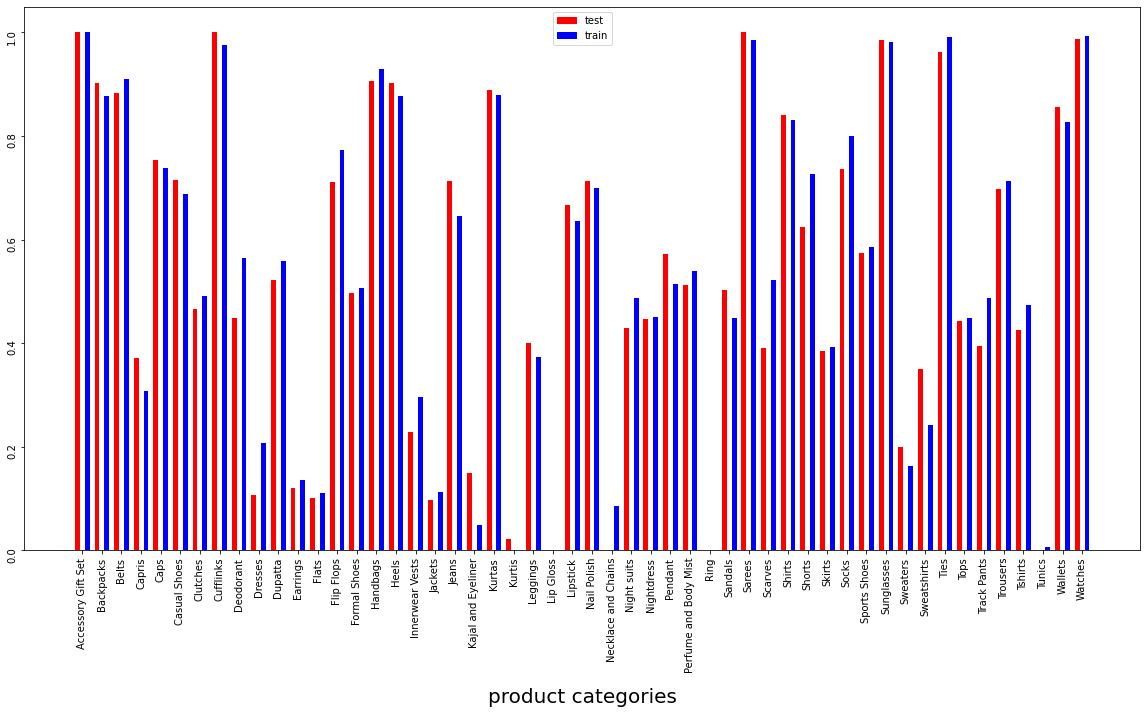

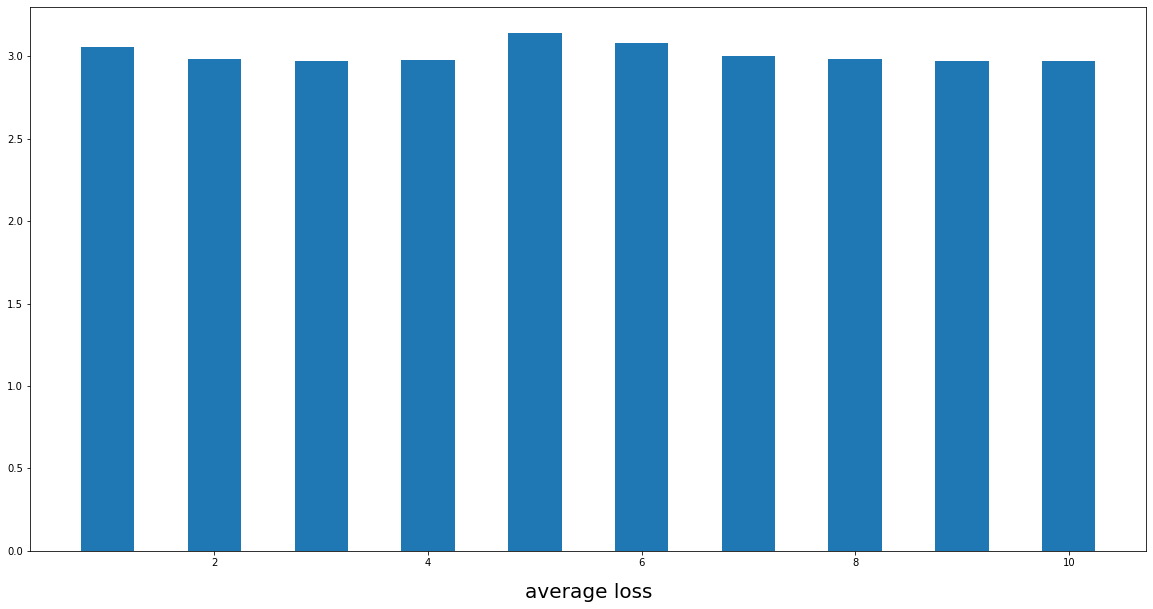

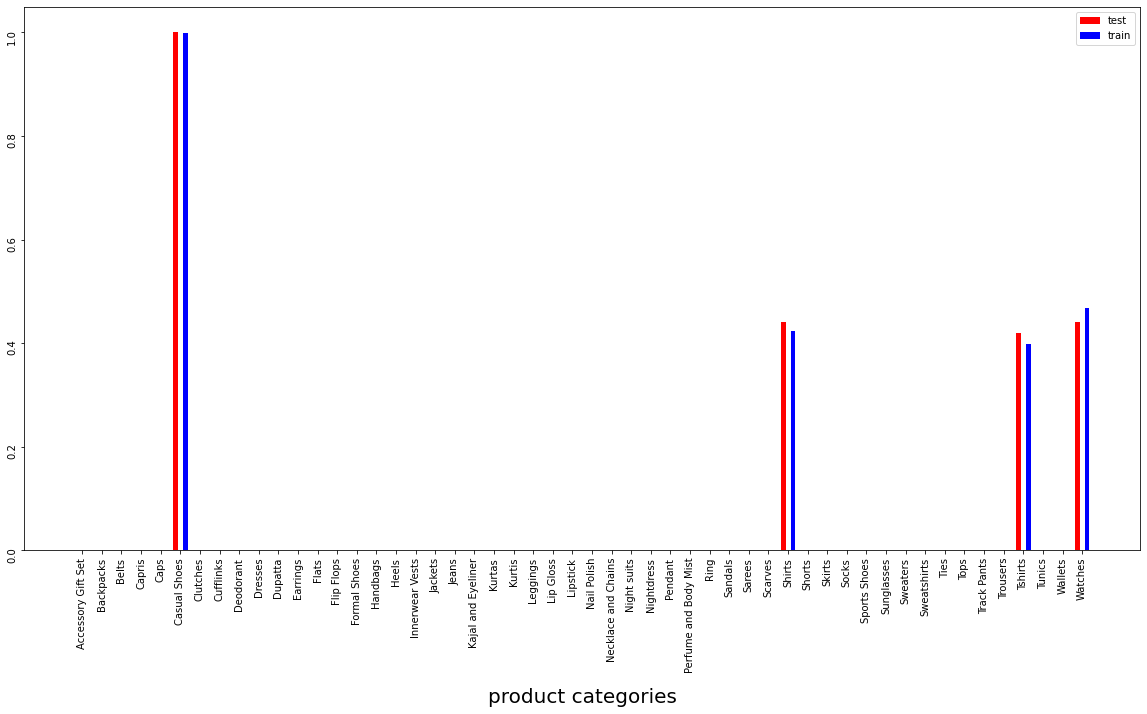

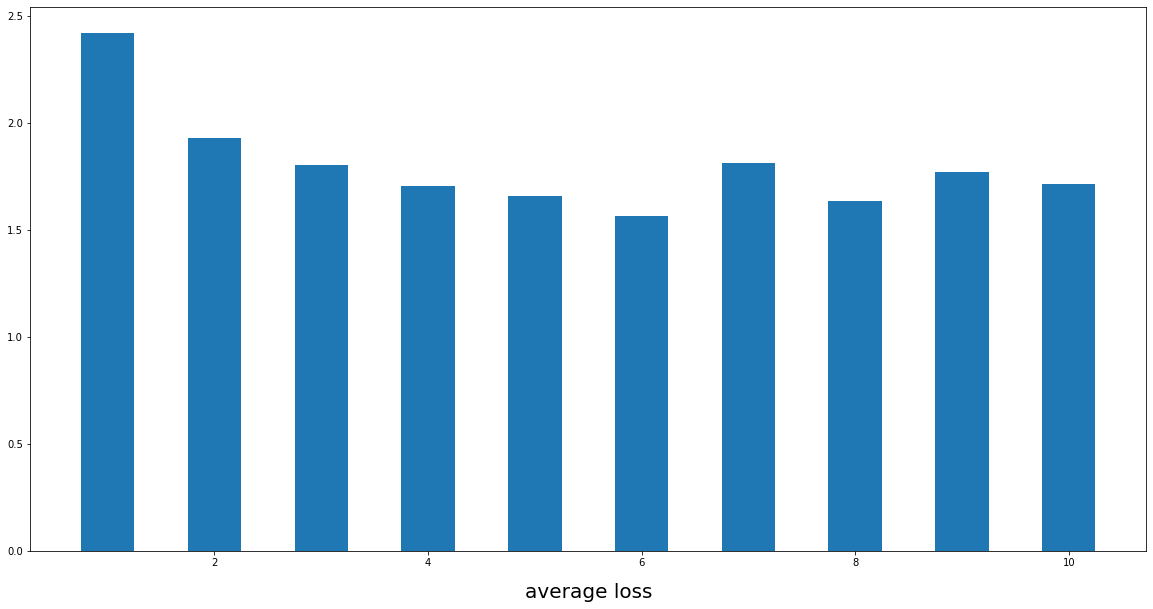

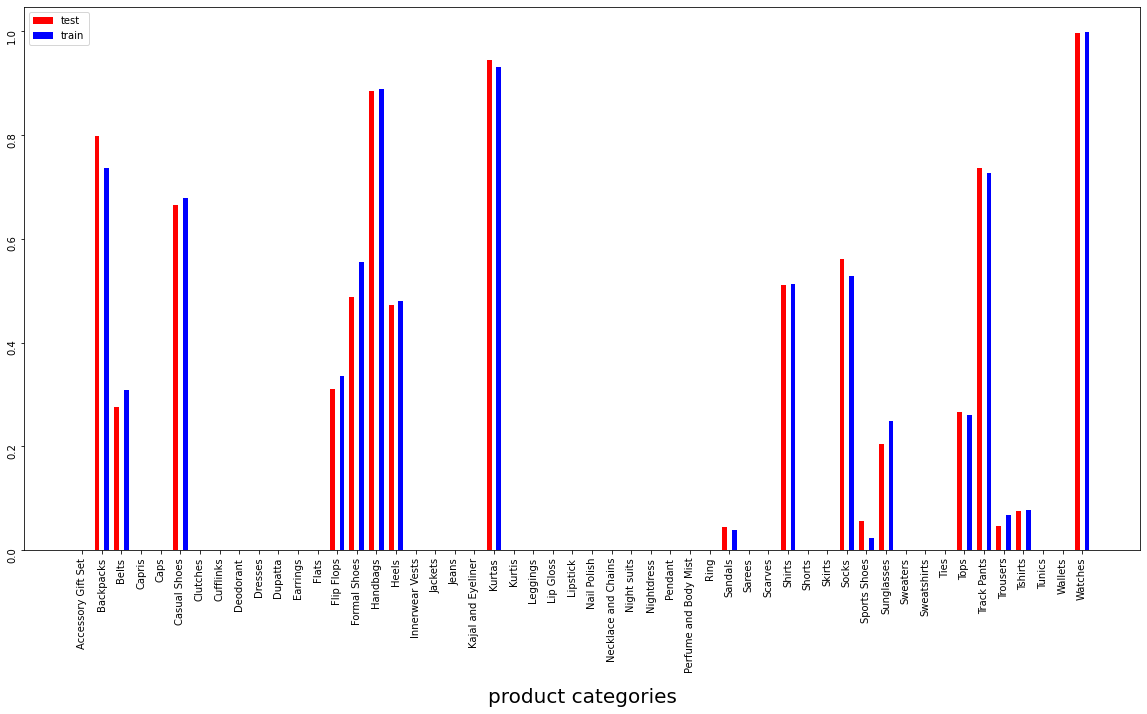

In [ ]:
weight_decays = [
    0,
    0.1,
    0.01,
]

for w in weight_decays:
    evaluate_model(
        model_config=best_layer_config,
        learning_rate=best_learning_rate,
        momentum=best_momentum,
        weight_decay=w
    )

By adding the regulizer term we can prevent overfitting. This is done by adding a squared magnitude term of weights to loss function, that will prevent weights (coefficients) getting large. So with smaller weights we have less overfit models.

In SGD optimizer this can be done by using the weight decay parameter which can be proved is equal to L2 regularization method ([Ref](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c)).

But in out model, adding weight decay to optimzer results in lower accuracy.